# О проекте
<a id='target100'></a>

На текущем варианте лендинга пользователь сначала выбирает ритейлера, переходит в каталог, ищет нужные ему товары и только потом может узнать, что из выбранного магазина доставка по его адресу невозможна. А в тестовом варианте лендинга пользователи сначала вводят адрес доставки и только потом выбирают один магазин из предложенных. В команде продуктового менеджера надеются на то, что нововведение поднимет конверсию в добавление товара в корзину без повышения отказов с самого лендинга.

В проведённом A/B-эксперименте обнаружилось так много проблем, что единственный аналитик в команде потерял душевное равновесие и уехал восстанавливаться. Нужно выручить людей - во-первых, сделать выводы из проведённого эксперимента и, во-вторых, описать все найденные аномалии, неочевидные или странные зависимости, нестыковки в данных.

### План:

1. [Чтение данных](#target1)
2. [Чистота данных и дизайн эксперимента](#target2)
 1. [Замена типов переменных](#target3)
 2. [Несколько групп для одного пользователя](#target4)
 3. [Время проведения эксперимента](#target5)
 3. [Способ разделения на группы](#target6)
 4. [Можно ли пропустить лендинг](#target7)
 5. [Источник вызова модального окна](#target8)
 6. [Чем могут помочь сессии](#target9)
 7. [Формулировка метрик](#target10)
3. [A/B-тест метрик](#target11)
4. [Принятие решения](#target12)
 1. [Средний чек в группах](#target13)
 2. [Конверсия в покупку](#target14)

<a id='target1'></a>
## Чтение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as st
import seaborn as sns
import gc
from IPython.display import display
from my_module import *
from sqlalchemy import create_engine
from sqlalchemy.schema import MetaData
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import tt_ind_solve_power
from sklearn.ensemble import IsolationForest
from scipy.stats import norm

In [2]:
db_config = {'user': 'rouser',
             'pwd': 'ZI6MVnmi', 
             'host': '178.62.242.91',
             'port': 5433, 
             'db': 'sbermarket-test'}
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                            db_config['pwd'],
                                                            db_config['host'],
                                                            db_config['port'],
                                                            db_config['db']))
meta = MetaData()
meta.reflect(bind = engine)
print('Таблицы в базе данных:\n\n', ',\n'.join(meta.tables.keys()), sep = '')

Таблицы в базе данных:

ab_test_hit,
landing_viewed,
main_page_viewed,
address_change_initiated,
address_not_in_delivery_zone,
shop_selection_started,
shop_selected,
add_to_cart_clicked,
product_added,
order_completed


In [3]:
load_from_db = False
if load_from_db:
    users = pd.io.sql.read_sql('SELECT * FROM ab_test_hit', con = engine)
    sberm_landing = pd.io.sql.read_sql('SELECT * FROM landing_viewed', con = engine)
    retailer_main_page = pd.io.sql.read_sql('SELECT * FROM main_page_viewed', con = engine)
    typing_address = pd.io.sql.read_sql('SELECT * FROM address_change_initiated', con = engine)
    address_fail = pd.io.sql.read_sql('SELECT * FROM address_not_in_delivery_zone', con = engine)
    shop_selection = pd.io.sql.read_sql('SELECT * FROM shop_selection_started', con = engine)
    shop_selected = pd.io.sql.read_sql('SELECT * FROM shop_selected', con = engine)
    add_attempt = pd.io.sql.read_sql('SELECT * FROM add_to_cart_clicked', con = engine)
    add_success = pd.io.sql.read_sql('SELECT * FROM product_added', con = engine)
    orders = pd.io.sql.read_sql('SELECT * FROM order_completed', con = engine)
    for df, tname in zip([users, sberm_landing, retailer_main_page, typing_address, address_fail, 
                          shop_selection, shop_selected, add_attempt, add_success, orders], meta.tables.keys()):
        df.to_csv(f'{tname}.csv')
else:
    users = pd.read_csv('Career_Factory/AB Test Hit.csv')
    sberm_landing = pd.read_csv('Career_Factory/Landing Viewed.csv')
    retailer_main_page = pd.read_csv('Career_Factory/Main Page Viewed.csv')
    typing_address = pd.read_csv('Career_Factory/Address Change Initiated.csv')
    address_fail = pd.read_csv('Career_Factory/Address not in delivery zone.csv')
    shop_selection = pd.read_csv('Career_Factory/Shop Selection Started.csv')
    shop_selected = pd.read_csv('Career_Factory/Shop Selected.csv')
    add_attempt = pd.read_csv('Career_Factory/Add to cart clicked.csv')
    add_success = pd.read_csv('Career_Factory/Product Added.csv')
    orders = pd.read_csv('Career_Factory/Order Completed.csv')

In [4]:
display(users.head(3))

hit_at                          anonymous_id  \
0  2020-11-30 04:21:38.616 UTC  3e05a2dc-3922-4caf-b837-08fcb337c82e   
1  2020-12-01 20:24:04.363 UTC  7f00b6ca-7938-4866-a323-c520838f5ef9   
2  2020-11-28 20:16:52.901 UTC  91e9900e-2cc6-4362-92b4-9e6712a6918e   

           group device_type browser       os  
0        default     desktop      IE  Windows  
1        default     desktop      IE  Windows  
2  address_first     desktop      IE  Windows

In [5]:
display(users.info(memory_usage = 'deep'))
display(typing_address.info())
display(my_info(orders))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502784 entries, 0 to 502783
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   hit_at        502784 non-null  object
 1   anonymous_id  502784 non-null  object
 2   group         502784 non-null  object
 3   device_type   502784 non-null  object
 4   browser       502784 non-null  object
 5   os            502783 non-null  object
dtypes: object(6)
memory usage: 126.9 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103434 entries, 0 to 103433
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     103434 non-null  object
 1   anonymous_id  103434 non-null  object
 2   source        103434 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


None

type not_null_cnt nunique                 mean      min  \
timestamp      object        16650   16650     varchar        -        -   
anonymous_id   object        16650    8778     varchar        -        -   
order_sum     float64        16650   16650  continuous  6285.17  3.38245   

                 25%      50%     75%     max  
timestamp          -        -       -       -  
anonymous_id       -        -       -       -  
order_sum     2272.5  4112.04  7388.3  530038

Насчёт эксперимента:
1. В контрольной группе пользователь, прошедший через всю воронку, видит страницу ритейлера не меньше двух раз - перед попыткой добавления товара в корзину и после успешной проверки адреса. А в тестовой группе только один раз - после успешной проверки адреса и выбора магазина. Акцент сильно сместился: пользователям из контрольной группы предложен ритейлер, а пользователям из тестовой - услуга по доставке. 
2. Если между попыткой добавления товара в корзину и успешным добавлением проходит время, то в контрольной группе это время уходит на ввод и проверку адреса. В тестовой группе такая задержка может быть связана разве что с техническими нюансами.
3. Ввод и проверка адреса в идеале должны происходить лишь однажды - в первую сессию. Потом адрес записывается в куки и подгружается автоматически.
4. Таблицы 'Address Change Initiated', 'Shop Selection Started' и 'Shop Selected' содержат поле 'source', в котором записан источник, или родительская страница, приведшая пользователя к соответствующему этапу. Похоже, что это поле должно содержать 'landing' в логах тестовой группы и 'add_product' в логах контрольной группы.
5. Похоже, что каждому пользователю, участвующему в эксперименте, поставлены в соответствие один браузер, одна ОС и один тип устройства. Если так, то показывается ли тестовая версия сайта тем, кто начинает сессию с нового браузера, ОС или устройства? 
6. В эксперименте участвуют новые пользователи или старые? Если новые, то как получается определить пользователя в некоторую группу ('AB Test Hit') ещё до того, как он в первый раз зайдёт на сайт ('Landing Viewed')? Если старые, то почему им вообще показывается лендинг? Это такие пользователи, которые ни разу не вводили адреса и не оформляли доставку

Насчёт данных: 
1. Все категориальные столбцы и уникальные идентификаторы, кроме 'retiler_id', записаны в строковом формате. Уникальные идентификаторы можно заменить на целые числа, категориальные - тоже, подготовив перед этим таблицы соответствия. Так мы облегчим данные. 
2. Формат UTC, в котором записаны поля 'timestamp', это время по Гринвичу. Если так, то имеет смысл ко всем временным отметкам прибавить три часа, получив московское время. Добавление символов 'UTC' ко всем строкам совершенно лишнее. Если требуется обратить внимание на то, что время записано именно в этом формате, лучше изменить название колонки. 
3. Хочется объединить все таблицы, кроме пользовательских данных, в один событийный лог. Отдельно от лога будут хранится сумма заказа (поле 'order_sum' таблицы 'Order Completed') и значение поля 'source'. 
4. Один пропуск в первой таблице и как минимум один выброс в последней таблице (стоимость покупки): 530 тысяч за покупку в продуктовом. Это в рублях?

In [6]:
# проверка на пропуски
for df in [users, sberm_landing, retailer_main_page, typing_address, address_fail, 
           shop_selection, shop_selected, add_attempt, add_success, orders]:
    probable_nans = df.isna().sum()
    columns_with_nans = probable_nans[ probable_nans >= 1 ]
    if any(columns_with_nans.index):
        [print(f'"{col}": {columns_with_nans[col]} пропусков') for col in columns_with_nans.index]

"os": 1 пропусков


In [7]:
display(users[ users['os'].isna() ])

hit_at                          anonymous_id  \
353476  2020-11-26 08:04:14.164 UTC  43c2bbe6-ba74-4b76-9597-421d3175ad30   

          group device_type  browser   os  
353476  default     desktop  Firefox  NaN

Проверим, равномерно ли поделены между группами пользователи.

In [8]:
# у plotly есть трудности с big data, но можно сократить выборку случайным образом
title = 'Как поделены между группами пользователи<br>пользующиеся разными устройствами, браузерами и ОС'
few_groups_distribution(users.sample(40000, random_state = 0), grouper = 'group', vars_type = 'discrete',
                        discrete_vars = ['os', 'browser', 'device_type'], 
                        title = title)

<a id='target2'></a>
## Чистота данных и дизайн эксперимента
[// вернуться к началу](#target100) 

<a id='target3'></a>
### Замена типов переменных

In [9]:
# заменим числами все значения категориальных переменных, таблицей соответствия будет словарь 'all_maps'
all_maps = {}
for colname in users.iloc[:, 1:].select_dtypes(['object']).columns:
    all_maps[colname] = {}
    for i, obj in enumerate(users[colname].unique()):
        all_maps[colname].update({obj: i})
    users[colname] = users[colname].map(all_maps[colname])

# вместо 'anonymous_id' уникальные целые числа
sberm_landing['anonymous_id'] = sberm_landing['anonymous_id'].map(all_maps['anonymous_id'])
retailer_main_page['anonymous_id'] = retailer_main_page['anonymous_id'].map(all_maps['anonymous_id'])
typing_address['anonymous_id'] = typing_address['anonymous_id'].map(all_maps['anonymous_id'])
address_fail['anonymous_id'] = address_fail['anonymous_id'].map(all_maps['anonymous_id'])
shop_selection['anonymous_id'] = shop_selection['anonymous_id'].map(all_maps['anonymous_id'])
shop_selected['anonymous_id'] = shop_selected['anonymous_id'].map(all_maps['anonymous_id'])
add_attempt['anonymous_id'] = add_attempt['anonymous_id'].map(all_maps['anonymous_id'])
add_success['anonymous_id'] = add_success['anonymous_id'].map(all_maps['anonymous_id'])
orders['anonymous_id'] = orders['anonymous_id'].map(all_maps['anonymous_id'])

for df in [users, sberm_landing, retailer_main_page, typing_address, address_fail, 
           shop_selection, shop_selected, add_attempt, add_success, orders]:
    
    # формат записи непостоянный - где-то указаны миллисекунды, где-то нет. там, где указаны, в строке 
    # присутствует точка. разделю датафрейм на несколько частей и применю к ним функции с разными параметрами. 
    # поскольку работает приведение типов, после этого нужно вручную сделать 'astype'
    datetime_colname = 'hit_at' if (df.shape[1] > 3) else 'timestamp'
    mask = df[datetime_colname].apply(lambda x: '.' in x)
    df.loc[mask, datetime_colname] = pd.to_datetime(df[mask][datetime_colname], format = '%Y-%m-%d %H:%M:%S.%f UTC',
                                              infer_datetime_format = True)
    df.loc[~mask, datetime_colname] = pd.to_datetime(df[~mask][datetime_colname], format = '%Y-%m-%d %H:%M:%S UTC',
                                               infer_datetime_format = True)
    df[datetime_colname] = df[datetime_colname].astype('datetime64[ns]')

# понижающее приведение и переименуем 'anonymous_id' в просто 'id'
users = downcast_convertion(users).rename({'anonymous_id': 'id'}, axis = 1)
sberm_landing = downcast_convertion(sberm_landing).rename({'anonymous_id': 'id'}, axis = 1)
retailer_main_page = downcast_convertion(retailer_main_page).rename({'anonymous_id': 'id'}, axis = 1)
typing_address = downcast_convertion(typing_address).rename({'anonymous_id': 'id'}, axis = 1)
address_fail = downcast_convertion(address_fail).rename({'anonymous_id': 'id'}, axis = 1)
shop_selection = downcast_convertion(shop_selection).rename({'anonymous_id': 'id'}, axis = 1)
shop_selected = downcast_convertion(shop_selected).rename({'anonymous_id': 'id'}, axis = 1)
add_attempt = downcast_convertion(add_attempt).rename({'anonymous_id': 'id'}, axis = 1)
add_success = downcast_convertion(add_success).rename({'anonymous_id': 'id'}, axis = 1)
orders = downcast_convertion(orders).rename({'anonymous_id': 'id'}, axis = 1)

display(users.info(memory_usage = 'deep'))
display(users.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502784 entries, 0 to 502783
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   hit_at       502784 non-null  datetime64[ns]
 1   id           502784 non-null  uint32        
 2   group        502784 non-null  uint8         
 3   device_type  502784 non-null  uint8         
 4   browser      502784 non-null  uint8         
 5   os           502784 non-null  uint8         
dtypes: datetime64[ns](1), uint32(1), uint8(4)
memory usage: 7.7 MB


None

hit_at      id  group  device_type  browser  os
26205  2020-12-09 16:07:16.185   25422      0            1        7   1
49263  2020-12-10 01:47:31.580   48391      0            0        7   2
135081 2020-11-29 12:14:24.674  133183      0            1        7   4
85412  2020-11-29 14:07:14.921   84260      0            1        7   4
332762 2020-11-26 10:50:00.749  324611      0            0       13   0

Использование памяти первой, самой тяжёлой таблицы, сократилось на порядок - со 126.9 МБ до 7.7 МБ.

<a id='target4'></a>
### Несколько групп для одного пользователя
[// вернуться к началу](#target100) 

In [10]:
# выведет на экран, какими числами закодированы группы
display(all_maps['group'])

# проверим, чтобы каждый пользователь был записан только в одну группу 
groups_num = users.groupby('id')['group'].nunique()
print('Уникальных пользователей всего: ', groups_num.shape[0])
in_one_group = groups_num[ groups_num == 1 ].index
rows_per_person = users[ users.id.isin(in_one_group) ].groupby('id')['group'].count()
in_one_group_few_times = rows_per_person[ rows_per_person > 1 ].index
in_both_groups = groups_num[ groups_num > 1 ].index
print('Пользователей, записанных в обе группы: ', len(in_both_groups))
print('Пользователей, записанных в одну группу несколько раз: ', len(in_one_group_few_times))
my_display(users[ users.id.isin(in_one_group) ].group.value_counts(), index_name = 'Группа',
           col_names = ['кол-во уникальных пользователей'])

{'default': 0, 'address_first': 1}

Уникальных пользователей всего:  489019
Пользователей, записанных в обе группы:  528
Пользователей, записанных в одну группу несколько раз:  10592


кол-во уникальных пользователей
Группа                                 
0                                445878
1                                 55748

Насчёт тех, кто бывал несколько раз записан в одну и ту же группу. Первое предположение - что новая запись делалась тогда, когда пользователь заходил с другого устройства, браузера или ОС (чтобы поддержать предельную точность, с которой, как мы видели, между группами поделены разные типы устройств, браузеры или ОС). Второе предположение - что этот баг сам связан с определённым устройством, браузером или ОС.

In [11]:
print('Уникальных значений разных переменных у тех пользователей, кто бывал '
      'записан в одну группу несколько раз:')
temp = users[ users.id.isin(in_one_group_few_times) ].sort_values(by = ['id', 'hit_at'])
my_display(temp.groupby('id').nunique().mean(), 
           col_names = ['Среднее кол-во уникальных значений'], index_name = 'Переменная')

print('\nГруппа, в которую они записаны:')
my_display(temp.groupby('id')['group'].last().value_counts(), 
           index_name = 'Группа', col_names = ['Кол-во уникальных пользователей'])

print('\nИх браузер:')
my_display(temp['browser'].value_counts().head(3), 
           index_name = 'Браузер', col_names = ['Кол-во записей'])

print('\nТип их устройства:')
my_display(temp['device_type'].value_counts().head(3), 
           index_name = 'Тип устройства', col_names = ['Кол-во записей'])

print('\nИх ОС:')
my_display(temp['os'].value_counts().head(3), 
           index_name = 'ОС', col_names = ['Кол-во записей'])

print('\nВремя, прошедшее между присвоением группы и переменой группы')
my_display(temp['hit_at'].sub(temp.groupby('id')['hit_at'].shift(1)).dropna().describe())

Уникальных значений разных переменных у тех пользователей, кто бывал записан в одну группу несколько раз:


Среднее кол-во уникальных значений
Переменная                                     
hit_at                                 2.240087
group                                  1.000000
device_type                            1.006231
browser                                1.005381
os                                     1.005098


Группа, в которую они записаны:


Кол-во уникальных пользователей
Группа                                 
0                                  9410
1                                  1182


Их браузер:


Кол-во записей
Браузер                
7                 10732
32                 5322
13                 2767


Тип их устройства:


Кол-во записей
Тип устройства                
1                        12418
0                        10983
2                          326


Их ОС:


Кол-во записей
ОС                
0             9653
4             6477
1             6308


Время, прошедшее между присвоением группы и переменой группы


hit_at
count                      13135
mean   3 days 05:43:22.408939322
std    3 days 02:24:49.996961047
min       0 days 00:00:00.006000
25%       0 days 22:33:16.654000
50%       2 days 01:26:12.205000
75%       4 days 21:22:23.112500
max      14 days 15:07:13.688000

Зашедшие с нового устройства были, но их около пятидесяти на десять тысяч. В среднем 2.24 повторные записи на человека. Ничего, что могло бы объяснить дубликаты. Поищем зацепки на тех, кто менял группу. Посмотрим на их данные, исключив такие записи, когда повторная запись есть, но группа не изменяется.

In [12]:
temp = users[ users.id.isin(in_both_groups) ].sort_values(by = ['id', 'hit_at'])
temp = temp[ temp['group'] != temp.groupby('id')['group'].shift(1) ]
print('Сколько перезаписей произошло:')
my_display(temp.groupby('id')['group'].count().value_counts(), 
           index_name = 'Кол-во перезаписей', col_names = ['Таких случаев в данных'])

print('\nПоследняя группа, в которую был записан пользователь:')
my_display(temp.groupby('id')['group'].last().value_counts(), 
           index_name = 'Группа', col_names = ['Кол-во уникальных пользователей'])

print('\nИх браузер:')
my_display(temp['browser'].value_counts().head(3), 
           index_name = 'Браузер', col_names = ['Кол-во записей'])

print('\nТип их устройства:')
my_display(temp['device_type'].value_counts().head(3), 
           index_name = 'Тип устройства', col_names = ['Кол-во записей'])

print('\nИх ОС:')
my_display(temp['os'].value_counts().head(3), 
           index_name = 'ОС', col_names = ['Кол-во записей'])

print('\nВремя, прошедшее между присвоением группы и переменой группы')
my_display(temp['hit_at'].sub(temp.groupby('id')['hit_at'].shift(1)).dropna().describe())

Сколько перезаписей произошло:


Таких случаев в данных
Кол-во перезаписей                        
2                                      492
3                                       29
4                                        4
5                                        2
6                                        1


Последняя группа, в которую был записан пользователь:


Кол-во уникальных пользователей
Группа                                 
1                                   294
0                                   234


Их браузер:


Кол-во записей
Браузер                
7                   498
35                  157
33                  128


Тип их устройства:


Кол-во записей
Тип устройства                
1                          878
0                          206
2                           19


Их ОС:


Кол-во записей
ОС                
4              834
0              174
1               65


Время, прошедшее между присвоением группы и переменой группы


hit_at
count                        575
mean      0 days 11:20:02.000520
std    1 days 17:47:23.273462552
min              0 days 00:00:00
25%       0 days 00:00:00.101500
50%       0 days 00:00:01.639000
75%       0 days 00:00:48.514500
max      14 days 02:19:39.811000

1. Чаще контрольная группа меняется на тестовую (1.25 к 1 при соотношении групп в выборке 1 к 10)
2. Промежуток между присвоением группы и переменой группы не очень большой - для половины наблюдений он не больше 2.25 секунд. Между дубликатами (предыдущий случай) промежутки были длиннее.
3. Зацепок по-прежнему нет. 

Есть данные из других таблиц. Возможно, объяснение найдётся в них. Возьмём утрированный случай - соберём в один лог все записи о пользователе, который менял группу 6 раз.

In [13]:
champion_id = temp.groupby('id')['group'].count().sort_values().index[-1]

# все данные в один датафрейм
logs = users[['hit_at', 'id']].rename({'hit_at': 'timestamp'}, axis = 1).copy()
logs['event'] = 0
all_maps['event'] = {'Определён в группу': 0}

for df, (i, event_name) in zip([sberm_landing, retailer_main_page, typing_address, address_fail, 
                           shop_selection, shop_selected, add_attempt, add_success, orders],
                           enumerate(['Лендинг', 'Каталог', 'Ввод адреса', 'Доставка невозможна', 
                                      'Выбор доступного магазина', 'Магазин выбран', 'Попытка добавить товар', 
                                      'Товар в корзине', 'Заказ сделан'], 1)):
    temp = df[['timestamp', 'id']].copy()
    temp['event'] = i
    all_maps['event'].update({event_name: i})
    logs = logs.append(temp)
    
# функции, с помощью которых можно в первоначальном и удобном для прочтения виде приводить фрагменты логов
reverse_event_map = dict(zip(all_maps['event'].values(), all_maps['event'].keys()))
reverse_id_map = dict(zip(all_maps['anonymous_id'].values(), all_maps['anonymous_id'].keys()))
def id_and_event_reverse_map(df):
    df = df.copy()
    df['event'] = df['event'].map(reverse_event_map)
    df['id'] = df['id'].map(reverse_id_map)
    return df
def find_source_for_address_window(row):
    if row.event != 3:
        return ''
    else:
        return typing_address.query('id == @row.id & timestamp == @row.timestamp')['source'].values[0]
def find_source_for_shop_selected(row):
    if row.event != 6:
        return ''
    else:
        return shop_selected.query('id == @row.id & timestamp == @row.timestamp')['source'].values[0]

logs = downcast_convertion(logs.sort_values(by = ['id', 'timestamp']).reset_index(drop = True))
champion_logs = logs[ logs.id == champion_id ].set_index('timestamp')[['id', 'event']].copy()
display(id_and_event_reverse_map(champion_logs))

id  \
timestamp                                                       
2020-11-28 14:37:56.306  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-11-28 14:37:56.306  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-11-28 14:37:56.427  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-04 08:26:53.348  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-04 08:26:53.396  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-04 08:26:53.472  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-05 18:21:59.725  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-05 18:21:59.755  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-05 18:21:59.768  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-10 06:35:50.949  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-10 06:35:50.983  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-10 06:35:51.047  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-10 12:43:13.676  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:18:09.892  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:44:40.803  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:44:54.154  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:45:21.711  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:50:30.315  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:50:34.360  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:51:28.212  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:51:37.217  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-13 16:51:57.733  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-16 08:00:34.234  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-16 14:03:09.490  e082144b-f119-4a82-9cfd-ee6f70bd5601   
2020-12-17 14:43:37.848  e082144b-f119-4a82-9cfd-ee6f70bd5601   

                                             event  
timestamp                                           
2020-11-28 14:37:56.306         Определён в группу  
2020-11-28 14:37:56.306         Определён в группу  
2020-11-28 14:37:56.427                    Лендинг  
2020-12-04 08:26:53.348                    Лендинг  
2020-12-04 08:26:53.396         Определён в группу  
2020-12-04 08:26:53.472         Определён в группу  
2020-12-05 18:21:59.725         Определён в группу  
2020-12-05 18:21:59.755                    Лендинг  
2020-12-05 18:21:59.768         Определён в группу  
2020-12-10 06:35:50.949                    Лендинг  
2020-12-10 06:35:50.983         Определён в группу  
2020-12-10 06:35:51.047         Определён в группу  
2020-12-10 12:43:13.676                    Лендинг  
2020-12-13 16:18:09.892                    Лендинг  
2020-12-13 16:44:40.803                    Лендинг  
2020-12-13 16:44:54.154                Ввод адреса  
2020-12-13 16:45:21.711                Ввод адреса  
2020-12-13 16:50:30.315                    Лендинг  
2020-12-13 16:50:34.360                Ввод адреса  
2020-12-13 16:51:28.212  Выбор доступного магазина  
2020-12-13 16:51:37.217             Магазин выбран  
2020-12-13 16:51:57.733                    Каталог  
2020-12-16 08:00:34.234                    Лендинг  
2020-12-16 14:03:09.490                    Лендинг  
2020-12-17 14:43:37.848                    Лендинг

На примере чемпиона по перезаписям не видно никакого триггера, который запускал бы перезапись группы. Иногда перезапись следует за действием, иногда происходит без повода. Но перезаписи закончились до того, как пользователь начал совершать взаимодействовать с сайтом, покинув лендинг. Верно ли это для остальных?

In [14]:
l_in_both_groups = logs[ logs.id.isin(in_both_groups) ].copy()
first_activity_date = l_in_both_groups[ ~l_in_both_groups.event.isin([0, 1]) ].groupby('id')['timestamp'].first()
l_in_both_groups['first_activity'] = l_in_both_groups.id.map(first_activity_date)
p_rate = l_in_both_groups[ l_in_both_groups.event == 0 ].apply(lambda x: (x.timestamp < 
                                                                                x.first_activity), axis = 1).mean()
print('Доля перезаписей группы уже после того момента, как пользователь '
      'начал проявлять активность на сайте: {:.2%}'.format(p_rate))

Доля перезаписей группы уже после того момента, как пользователь начал проявлять активность на сайте: 18.39%


...Это неверно. 18.39% - для нас неприемлимо абсолютно, так делать нельзя. Остальные 82% - тоже неприемлимо, ведь страница лендинга у групп отличается. 
- В лендинге для контрольной группы на первом плане магазины-партнёры и фраза "Выберите магазин и начинайте делать покупки"
- В лендинге для тестовой группы на первом плане поисковая строка и фраза "Введите адрес доставки и мы покажем...".

Поскольку цель проекта в том, чтобы сравнить дизайн лендингов, такая путаница в любом случае лишает возможности делать определённые выводы о тех пользователях, кого она коснулась. 

Вызывает подозрение, когда пользователь по нескольку раз записан в одну и ту же группу, но таких пользователей уже достаточно много (два процента), а явных причин избавляться от данных нет. 

<a id='target5'></a>
### Время проведения эксперимента
[// вернуться к началу](#target100) 

Эксперимент длился 21 days 23:21:36.368000


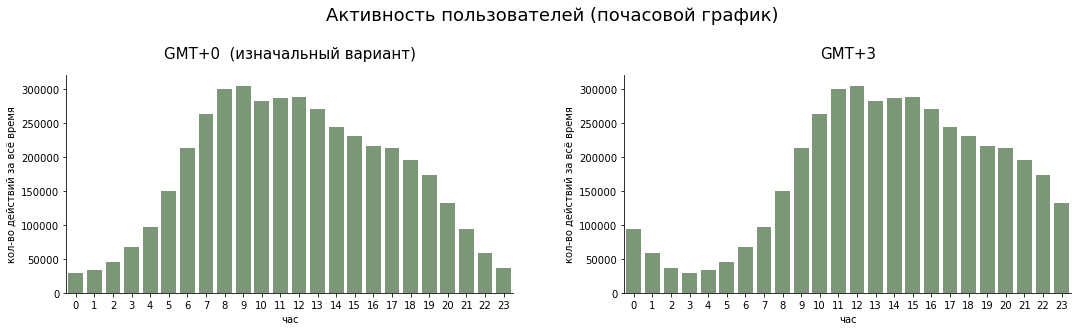

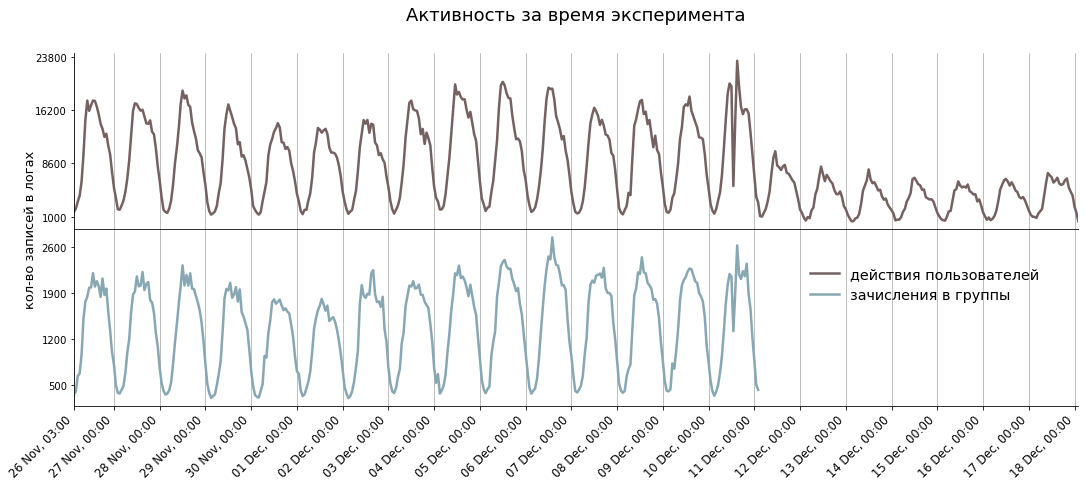

In [15]:
print('Эксперимент длился', logs.timestamp.max() - logs.timestamp.min())
def draw_activity_hours(df, ax):
    activity_hours = df.timestamp.dt.hour.value_counts().sort_index()
    sns.barplot(y = activity_hours, x = activity_hours.index, linewidth = 6, color = '#789b73', ax = ax)
    ax.set(xlabel = 'час', ylabel = 'кол-во действий за всё время')
    
fig, ax1, ax2 = two_subplots((18, 4), '', ['GMT+0  (изначальный вариант)', 'GMT+3'])
fig.suptitle('Активность пользователей (почасовой график)', y = 1.12, fontsize = 18)
draw_activity_hours(logs, ax1)
logs.timestamp = logs.timestamp + pd.Timedelta(3, 'h')
users.hit_at = users.hit_at + pd.Timedelta(3, 'h')
draw_activity_hours(logs, ax2)
display(fig)
plt.close(fig)

def time_series(df1, df2, title):
    df2 = df2.rename({'hit_at': 'timestamp'}, axis = 1)
    aux1 = (df1.timestamp.astype('datetime64[h]').value_counts().sort_index()
            .reset_index().rename({'index': 'targ'}, axis = 1))
    first_index_for_every_day = aux1['targ'].astype('datetime64[D]').reset_index().groupby('targ')['index'].first()
    xticks = first_index_for_every_day.reset_index().merge(aux1.reset_index(), on = 'index')
    fig = plt.figure(figsize = (18, 6.5))
    gs = fig.add_gridspec(2, 1, hspace = 0)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex = ax1)
    
    ax1.plot(aux1.targ, aux1.timestamp, linewidth = 2.5, color = '#766161', label = 'действия пользователей')
    aux = (df2.timestamp.astype('datetime64[h]').value_counts().sort_index()
            .reset_index().rename({'index': 'targ'}, axis = 1))
    ax2.plot(aux.targ, aux.timestamp, linewidth = 2.5, color = '#87a7b3', label = 'зачисления в группы')
    ax2.set(xticks = xticks.targ_y, xlim = (aux1.targ.min(), aux1.targ.max()), 
            yticks = np.linspace(500, ax2.get_yticks().max() - 400, 4))
    ax1.set(yticks = np.linspace(1000, ax1.get_yticks().max() - 1200, 4))
    ax2.set_ylabel('кол-во записей в логах', fontsize = 13, y = 1)
    ax1.set_title(title, fontsize = 18, y = 1.15)
    ax2.set_xticklabels(xticks.targ_y.dt.strftime('%d %h, %H:00'), rotation = 45, fontsize = 11.5, ha = 'right')
    ax1.grid(b = True, axis = 'x')
    ax2.grid(b = True, axis = 'x')
    ax1.tick_params(axis = 'x', bottom = False, labelbottom = False) 
    fig.legend(fontsize = 'x-large', bbox_to_anchor = (0.88, 0.45), frameon = False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.savefig('img1.png', bbox_inches = 'tight')
    display(fig)
    plt.close(fig)

print()
time_series(logs, users, title = 'Активность за время эксперимента')

# возвращаю время обратно к GMT+0, потому что неохота переписывать время в остальных датафреймах
logs.timestamp = logs.timestamp - pd.Timedelta(3, 'h')
users.hit_at = users.hit_at - pd.Timedelta(3, 'h')

Эксперимент начался 26 ноября (утро четверга). В течение двух недель, до 11 декабря (это была пятница) группы пополнялись новыми пользователями, и ещё неделю после этого их действия фиксировались. Несколько неудачно, что будних дней на один больше - всех дней недели по два, а четверга три. Профиль поведения на выходных и на буднях зачастую отличается, в том числе в нашем кейсе - доставку удобно заказывать именно в те дни, когда ты находишься дома. Но тестируемое нововведение не меняет профиль поведения в выходные или будние дни, поэтому недостаток несущественный.

10 декабря в середине дня был кратковременный сбой.

<a id='target6'></a>
### Способ разделения на группы
[// вернуться к началу](#target100) 

In [16]:
logs = logs.merge(users.groupby('id')['group'].first().reset_index(), on = 'id', how = 'inner')
first_event = logs.groupby(['group', 'id'])['event'].first().reset_index()
first_event['event'] = first_event['event'].map(reverse_event_map)
first_event_1 = first_event[ first_event.group == 1]['event'].value_counts()
first_event_0 = first_event[ first_event.group == 0]['event'].value_counts()
print('В числах - количество уникальных пользователей, для которых данное действие является первым')
my_display(first_event_0, col_names = ['Первое действие'], index_name = 'Контрольная группа')
my_display(first_event_1, col_names = ['Первое действие'], index_name = 'Тестовая группа')

В числах - количество уникальных пользователей, для которых данное действие является первым


Первое действие
Контрольная группа                        
Определён в группу                  355708
Лендинг                              59249
Каталог                              17897
Попытка добавить товар                 746
Магазин выбран                         395
Ввод адреса                            298
Выбор доступного магазина              131
Заказ сделан                            22
Товар в корзине                         18
Доставка невозможна                      1

Первое действие
Тестовая группа                           
Определён в группу                   44530
Лендинг                               7345
Каталог                               2289
Ввод адреса                            212
Попытка добавить товар                 109
Магазин выбран                          51
Выбор доступного магазина               18

Корректный эксперимент должен был быть спроектирован так, чтобы в нём участвовали только новые пользователи. Здесь не так.

Дальнейшие действия зависят от того, как мы будем рассматривать тех пользователей, кто был зачислен в одну из групп до того, как она случился первый показ какой-то страницы. 

In [17]:
print('Взяли пользователей, у которых первое событие - зачисление в группу.')
print('Время первого события вычитаем из времени следующего события:')
assigned_initially = first_event[ first_event.event == 'Определён в группу' ].id
assigned_initially_logs = logs[ logs.id.isin(assigned_initially) ].copy()
assigned_initially_logs['next_event_timestamp'] = assigned_initially_logs.groupby('id')['timestamp'].shift(-1)
no_next_event = assigned_initially_logs['next_event_timestamp'].isna().mean()
assigned_initially_logs = assigned_initially_logs.dropna().groupby('id').agg({'timestamp': 'first', 
                                                                     'next_event_timestamp': 'first'})
assigned_initially_logs['delay'] = assigned_initially_logs.iloc[:, 1].sub(assigned_initially_logs.iloc[:, 0])
my_display(assigned_initially_logs['delay'].describe())
print('Среди взятых пользователей доля тех, у которых разница во времени между двумя событиями больше 0.5 секунд: ',
      '{:.3%}'.format((assigned_initially_logs['delay'] > '0.5 seconds').mean()))
print('Доля тех, у кого зачисление в группу было последним из событий: ', '{:.3%}'.format(no_next_event))

Взяли пользователей, у которых первое событие - зачисление в группу.
Время первого события вычитаем из времени следующего события:


delay
count                     209957
mean   0 days 04:08:30.189290011
std    1 days 05:49:06.984007147
min              0 days 00:00:00
25%              0 days 00:00:00
50%       0 days 00:00:00.002000
75%       0 days 00:00:00.256000
max      21 days 10:04:40.332000

Среди взятых пользователей доля тех, у которых разница во времени между двумя событиями больше 0.5 секунд:  23.812%
Доля тех, у кого зачисление в группу было последним из событий:  16.134%


Посмотрим на тот же показатель для тех пользователей, кто сначала попал в лог, а потом был отнесён к некоторой группе.

In [18]:
print('Взяли пользователей, у которых первым событием в логах было НЕ зачисление в группу.')
print('Из времени зачисления в группу вычитаем время предыдущего события:')
assigned_afterwards = first_event[ first_event.event != 'Определён в группу' ].id
assigned_afterwards_logs = logs[ logs.id.isin(assigned_afterwards) ].copy()
assigned_afterwards_logs['previous_event_timestamp'] = assigned_afterwards_logs.groupby('id')['timestamp'].shift(1)
assigned_afterwards_logs['next_event_timestamp'] = assigned_afterwards_logs.groupby('id')['timestamp'].shift(-1)
assigned_afterwards_logs = assigned_afterwards_logs.query('event == 0')
no_next_event = assigned_afterwards_logs['next_event_timestamp'].isna().mean()
assigned_afterwards_logs = assigned_afterwards_logs.groupby('id').agg({'timestamp': 'first', 
                                                                       'previous_event_timestamp': 'first'})
assigned_afterwards_logs['delay'] = assigned_afterwards_logs.iloc[:, 0].sub(assigned_afterwards_logs.iloc[:, 1])
my_display(assigned_afterwards_logs['delay'].describe())
print('Среди взятых пользователей доля тех, у которых разница во времени между двумя событиями больше 40 секунд: ',
      '{:.3%}'.format((assigned_afterwards_logs['delay'] > '40 seconds').mean()))
print('Доля тех, у кого зачисление в группу было последним из событий: ', '{:.3%}'.format(no_next_event))

Взяли пользователей, у которых первым событием в логах было НЕ зачисление в группу.
Из времени зачисления в группу вычитаем время предыдущего события:


delay
count                      88781
mean   0 days 03:05:22.574575652
std    0 days 22:32:26.825349276
min       0 days 00:00:00.001000
25%       0 days 00:00:00.001000
50%       0 days 00:00:00.015000
75%       0 days 00:00:00.121000
max      14 days 06:32:39.655000

Среди взятых пользователей доля тех, у которых разница во времени между двумя событиями больше 40 секунд:  5.028%
Доля тех, у кого зачисление в группу было последним из событий:  42.726%


Иногда зачисление в группу не только сильно опережало первое действие, но и сильно запаздывало.

In [19]:
strange_situation_id = 8775
if strange_situation_id in assigned_afterwards.values:
    strange_situation_logs = id_and_event_reverse_map(logs[ logs.id == strange_situation_id ].head(7))
    display(strange_situation_logs)
    draw_table(strange_situation_logs, mode = 'save', colwidths = [0.35, 0.35, 0.15, 0.15], save_name = 'table6.png')

timestamp                                    id  \
110237 2020-11-28 15:11:54.982  050674f7-f90a-40db-9193-6d49365cf478   
110238 2020-12-10 12:09:44.114  050674f7-f90a-40db-9193-6d49365cf478   
110239 2020-12-11 10:55:15.403  050674f7-f90a-40db-9193-6d49365cf478   
110240 2020-12-11 10:55:45.543  050674f7-f90a-40db-9193-6d49365cf478   
110241 2020-12-11 10:55:55.729  050674f7-f90a-40db-9193-6d49365cf478   
110242 2020-12-11 10:55:59.923  050674f7-f90a-40db-9193-6d49365cf478   
110243 2020-12-11 10:56:52.584  050674f7-f90a-40db-9193-6d49365cf478   

                     event  group  
110237             Каталог      0  
110238  Определён в группу      0  
110239             Лендинг      0  
110240             Каталог      0  
110241      Магазин выбран      0  
110242             Каталог      0  
110243      Магазин выбран      0

Если зачисление может быть последним из событий, значит, зачисление не привязано к активности пользователей. Если так, то будем иметь таких пользователей, которые вообще ни разу не появлялись на сайте.

In [20]:
just_one_event = logs.groupby('id')['event'].count() == 1
just_one_event = just_one_event[ just_one_event ].index
print('Количество пользователей, о которых в логах только одна запись за всё время наблюдения: ', len(just_one_event))
just_one_event = logs[ logs.id.isin(just_one_event) ]
print('События, записанные для этих пользвателей:')
my_display(just_one_event['event'].value_counts(), 
           index_name = 'Код события', col_names = ['записей в логах'])
print('Уникальных временных отметок для таких записей: ', just_one_event.timestamp.nunique())

Количество пользователей, о которых в логах только одна запись за всё время наблюдения:  190281
События, записанные для этих пользвателей:


записей в логах
Код события                 
0                     190281

Уникальных временных отметок для таких записей:  190236


Почти 40% от всех уникальных пользователей были записаны в какую-то из групп, но не разу ни зашли ни на одну страницу сайта. И дело не в кратковременных сбоях, иначе уникальных временных отметок было бы значительно меньше, чем уникальных записей.

С другой стороны, есть около 250'000 уникальных пользователей, у которых между временем зачисления в группу и первым просмотром сайта прошло меньше 0.5 секунды времени.

И есть относительно небольшая группа уникальных пользователей, у которых между зачислением и первым заходом прошло довольно длительное время. Складывается впечатление, что одновременно работают два механизма привлечения трафика в эксперимент: 
1. один скрипт зачисляет пользователя в группу, получая от него запрос к серверу (то есть, скрипт включается тогда, когда пользователь заходит на сайт), 
2. второй скрипт орудует какой-то исторической базой и распределяет "старых" пользователей по группам. Некоторые из этой исторической базы вновь появляются на сайте, и тогда мы видим большую задержку во времени между зачислением и первым визитом, но большая часть из них не появляются - это те самые 190'000 тысяч, которые только что обнаружились.

Если так, то возможно, что задвоения группы и перезаписи группы могут быть отчасти связаны с тем, что эти два скрипта накладываются на одних и тех же пользователей. Пользователь заходит на сайт и первый скрипт зачисляет его в одну из групп. После этого он попадает в историческую базу, и спустя какое-то время его в этой базе находит второй скрипт и снова зачисляет в одну из групп.

Для проверки можно посмотреть на гистограмму модуля задержки:
- Задержки меньше 0.5 секунд по модулю могут быть связаны с тем, что данные с разной скоростью заносились в разные таблицы (логи эксперимента хранились в разных таблицах, по одной на каждое событие). Тогда из логов может следовать как то, что пользователь сначала был зачислен в группу, а через миллисекунды зашёл на какую-то страницу, так и наоборот - сначала зашёл на страницу, а спустя миллисекунды зачислен. Взятие модуля нейтрализует эту случайность.
- Минусовые большие задержки говорят о том, что пользователь сначала зашёл на сайт, и лишь спустя долгое время был включён в эксперимент из исторической базы. Плюсовые большие задержки - что "старого" пользователя сначала включили в эксперимент, а спустя какое-то время он зашёл на сайт. Оба случая говорят о работе второго скрипта, поэтому взятие модуля, которое уравняет эти случаи, здесь тоже уместно. 

In [21]:
first_events = logs[ logs.event == 0 ].groupby('id')['timestamp'].first().reset_index()
first_events = first_events.merge(logs[ logs.event != 0 ].groupby('id')['timestamp'].first().reset_index(), on = 'id')
first_events['delay_abs'] = abs(first_events.iloc[:, 1].sub(first_events.iloc[:, 2])) / np.timedelta64(1, 's')

Неизвестно, как распределены задержки первого скрипта, однако в самом крайнем случае они вряд ли превысят несколько десятков секунд. У второго скрипта задержки должны быть распределены равномерно. Несколько десятков секунд от зачисления в группу какого-то известного старого пользователя до его появления на сайте - довольно редкое совпадение.

Если предположения верны, то понемногу увеличивая задержку, служащую порогом для разделения пользователей на две группы, мы рано или поздно выйдём плато по доле пользователей в группах.

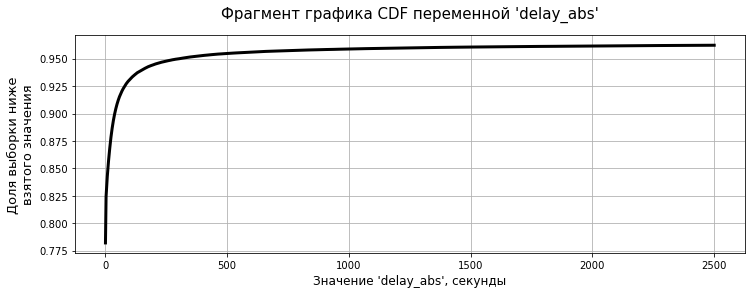

In [22]:
x = np.linspace(0.2, 2500, 1000)
y = ECDF(first_events['delay_abs'])(x)

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(x, y, linewidth = 3, color = 'k')
ax.set_xlabel("Значение 'delay_abs', секунды", fontsize = 12)
ax.set_ylabel('Доля выборки ниже\nвзятого значения', fontsize = 13)
ax.set_title("Фрагмент графика CDF переменной 'delay_abs'", fontsize = 15, y = 1.05)
ax.grid(b = True, axis = 'both')
plt.savefig('img2.png', bbox_inches = 'tight', pad_inches = 0)
display(fig)
plt.close(fig)

Пусть порогом будет 900 секунд задержки (ровно 15 минут). Если задержка между зачислением в группу и первым появлением в событийных логах превышает 15 минут, будем считать, что пользователь взят из архивной базы пользователей, а если не превышает 15 минут - что он был зачислен в некоторую группу одновременно с первым появлением на сайте. Таким образом, в одной группе окажется примерно 96% пользователей, в другой - 4% пользователей.

Насколько эта группировка проливает свет на проблему с повторяющимися зачислениями в группы?

In [23]:
archive_users = first_events[ first_events['delay_abs'] > 1000 ]['id'].values
fresh_users = first_events[ first_events['delay_abs'] <= 1000 ]['id'].values

In [24]:
few_times_in_one_group = []
for ids_list, group_name in zip([fresh_users, archive_users], 
                                ['Меньше 4х минут задержки', 'Больше 4х минут задержки']):
    groups_num = users[ users.id.isin(ids_list) ].groupby('id')['group'].nunique()
    print(f"Группа '{group_name}'")
    print('{: >55}'.format('Уникальных пользователей всего: '), groups_num.shape[0])
    in_one_group = groups_num[ groups_num == 1 ].index
    rows_per_person = users[ users.id.isin(in_one_group) ].groupby('id')['group'].count()
    in_one_group_few_times = rows_per_person[ rows_per_person > 1 ].index
    few_times_in_one_group.append(in_one_group_few_times)
    print('Пользователей, записанных в одну группу несколько раз: ', len(in_one_group_few_times))
    print('{: >55}'.format('Их доля от всей группы: '), 
          '{:.2%}'.format(len(in_one_group_few_times) / groups_num.shape[0]))
    print()

Группа 'Меньше 4х минут задержки'
                       Уникальных пользователей всего:  284572
Пользователей, записанных в одну группу несколько раз:  6604
                               Их доля от всей группы:  2.32%

Группа 'Больше 4х минут задержки'
                       Уникальных пользователей всего:  12185
Пользователей, записанных в одну группу несколько раз:  2299
                               Их доля от всей группы:  18.87%



In [25]:
# для приличия
zstat, p_value = proportions_ztest([6604, 2299], [284572, 12185])
print('Z-статистика:', zstat)
print('p-value равенства пропорций в группах:', p_value)

Z-статистика: -104.85002972226339
p-value равенства пропорций в группах: 0.0


Задержка однозначно является значимым признаком при предсказании аномалии с повторными зачислениями в группу. 
Это говорит о том, что предложенная интерпретация не далека от истины. Если так, то в некоторых случаях второй скрипт накладывается на первый. 

Первый скрипт обрабатывает тех, кто в реальном времени пытается попасть на сайт. Это могут быть как новые, так и старые пользователи - алгоритм отличаться от этого не должен. Второй скрипт обрабатывает архив, и тут два варианта: либо архив обновляется по ходу эксперимента, либо нет. Допустим, что он не обновляется - итерироваться по данным, которые обновляются в режиме реального времени, трудно и неоправданно. Тогда следует, что те 2.32% (6'604 пользователя) из первой группы - это старые пользователи, иначе их группа не была бы перезаписана.

Этих подозрений, мне кажется, достаточно, чтобы исключить из рассмотрения и их тоже. Если допущение окажется неверным, то мы потеряем 2.32% корректных данных. Данных, навскидку, и без этих двух процентов будет достаточно, чтобы зафиксировать даже небольшие различия в bounce rate и в конверсии.

Что плохо со старыми пользователями в эксперименте?
- В несбалансированных группах (как у нас - размеры контрольной и тестовой группы соотносятся как 9:1), нет особых проблем до тех пор, пока группы однородны. Если же группы внутри себя группируются ещё по каким-то признакам, и эти "внутренние" группы значимо отличаются в целевой метрике (нет сомнений, что новые и старые пользователи значимо отличаются как в bounce rate с лендинга, так и в конверсии в добавление товара), то при малейшем сдвиге их соотношения от 9:1 начинается парадокс Симпсона.
- Старых пользователей не получится отследить - в данных нет ни одной переменной, описывающей lifetime пользователя. Значит, любой результат теста будет для нас "чёрным ящиком". Неизвестно, чем закончились их предыдущие посещения.
- Конверсия старых пользователей никак не связана с тем, что мы тестируем. У большинства из них уже есть опыт добавления товара в корзину, многие уже делали заказ. Их поведение во время эксперимента совершенно нерепрезентативно в контексте группы, в которую они зачислены.

Мы нашли "старых" по косвенному признаку - по разнице между временем зачисления в группу и первым появлением на сайте. Кажется, что есть более прямой путь - у пользователей, которые хотя бы раз добавляли товар в корзину, но ни разу не вводили свой адрес, адрес должен быть уже сохранён в куках. Ни в одной версии сайта новый пользователь не может положить товар в корзину, не введя адрес. В контрольной группе он может **попытаться** положить, но тогда откроется модальное окно, и ему придетёся ввести адрес и выбрать при необходимости другой магазин, и только после этого товар окажется в корзине.

In [26]:
typed_address = logs.query('event == 3')['id'].unique()
passed_the_funnel = set(logs.query('event == 8').id.unique())
added_without_checking_address = list(passed_the_funnel.difference(passed_the_funnel.intersection(typed_address)))

id_for_example = 327710
print('Для примера, логи пользователя, которого следует отнести к старым:')
logs_for_example = logs[ logs.id == id_for_example ].copy()
logs_for_example['source'] = logs_for_example.apply(find_source_for_shop_selected, axis = 1)
logs_for_example = id_and_event_reverse_map(logs_for_example)
draw_table(logs_for_example, mode = 'save', colwidths = [0.25, 0.3, 0.25, 0.05, 0.05, 0.1], save_name = 'table1.png')
display(logs_for_example)

Для примера, логи пользователя, которого следует отнести к старым:


timestamp                                    id  \
3164488 2020-12-03 08:13:46.319  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164489 2020-12-03 08:13:46.320  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164490 2020-12-03 08:14:47.699  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164491 2020-12-03 08:15:06.854  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164492 2020-12-03 08:15:11.609  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164493 2020-12-03 08:18:09.392  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164494 2020-12-03 08:18:10.515  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164495 2020-12-03 08:18:42.250  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164496 2020-12-03 08:18:43.449  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164497 2020-12-03 08:20:04.924  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164498 2020-12-03 08:20:06.191  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164499 2020-12-03 08:23:39.867  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164500 2020-12-03 08:23:41.134  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164501 2020-12-03 08:24:07.267  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164502 2020-12-03 08:24:09.157  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164503 2020-12-03 08:25:53.831  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164504 2020-12-03 08:25:54.985  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164505 2020-12-03 08:28:29.916  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164506 2020-12-03 08:28:31.889  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164507 2020-12-03 08:35:10.538  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164508 2020-12-03 08:35:12.429  18f0eca2-be95-4235-82fd-ccbd0c497983   
3164509 2020-12-03 08:42:46.398  18f0eca2-be95-4235-82fd-ccbd0c497983   

                          event  group  source  
3164488                 Лендинг      1          
3164489      Определён в группу      1          
3164490                 Каталог      1          
3164491          Магазин выбран      1  header  
3164492                 Каталог      1          
3164493  Попытка добавить товар      1          
3164494         Товар в корзине      1          
3164495  Попытка добавить товар      1          
3164496         Товар в корзине      1          
3164497  Попытка добавить товар      1          
3164498         Товар в корзине      1          
3164499  Попытка добавить товар      1          
3164500         Товар в корзине      1          
3164501  Попытка добавить товар      1          
3164502         Товар в корзине      1          
3164503  Попытка добавить товар      1          
3164504         Товар в корзине      1          
3164505  Попытка добавить товар      1          
3164506         Товар в корзине      1          
3164507  Попытка добавить товар      1          
3164508         Товар в корзине      1          
3164509            Заказ сделан      1

In [27]:
groups_num = users[ users.id.isin(added_without_checking_address) ].groupby('id')['group'].nunique()
print(f"Группа тех, кто уже, предположительно, бывал на сайте.")
print('{: >55}'.format('Уникальных пользователей всего: '), groups_num.shape[0])
in_one_group = groups_num[ groups_num == 1 ].index
rows_per_person = users[ users.id.isin(in_one_group) ].groupby('id')['group'].count()
in_one_group_few_times = rows_per_person[ rows_per_person > 1 ].index
print('Пользователей, записанных в одну группу несколько раз: ', len(in_one_group_few_times))
print('{: >55}'.format('Их доля от всей группы: '), 
      '{:.2%}'.format(len(in_one_group_few_times) / groups_num.shape[0]))

Группа тех, кто уже, предположительно, бывал на сайте.
                       Уникальных пользователей всего:  20472
Пользователей, записанных в одну группу несколько раз:  1937
                               Их доля от всей группы:  9.46%


Перед тем, как что-либо удалять, выведу метрики при изначальных данных и при тривиальном способе подсчёта. Чтобы потом было с чем сравнивать.

In [28]:
logs = logs[ logs.event != 0 ].sort_values(by = ['id', 'timestamp'], ascending = True)

trials_b_gr0 = logs.query('event == 1 & group == 0')['id'].unique()
passed_the_landing_gr0 = logs[ logs.id.isin(trials_b_gr0) ].groupby('id')['event'].nunique()
passed_the_landing_gr0 = passed_the_landing_gr0[ passed_the_landing_gr0 > 1 ].index
trials_b_gr1 = logs.query('event == 1 & group == 1')['id'].unique()
passed_the_landing_gr1 = logs[ logs.id.isin(trials_b_gr1) ].groupby('id')['event'].nunique()
passed_the_landing_gr1 = passed_the_landing_gr1[ passed_the_landing_gr1 > 1 ].index

trials_c_gr0 = logs[ (logs.event != 1) & (logs.group == 0) ]['id'].unique()
passed_the_funnel_gr0 = logs[ (logs.event == 8) & (logs.group == 0) ]['id'].unique()
trials_c_gr1 = logs[ (logs.event != 1) & (logs.group == 1) ]['id'].unique()
passed_the_funnel_gr1 = logs[ (logs.event == 8) & (logs.group == 1) ]['id'].unique()

trials_c1_gr0 = passed_the_funnel_gr0
placed_an_order_gr0 = logs[ (logs.event == 9) & (logs.group == 0) ]['id'].unique()
trials_c1_gr1 = passed_the_funnel_gr1
placed_an_order_gr1 = logs[ (logs.event == 9) & (logs.group == 1) ]['id'].unique()

print('Bounce Rate')
print('{: <35}'.format('   - текущей версии лендинга: '), 
      '{:.2%}'.format(1 - len(passed_the_landing_gr0) / (len(trials_b_gr0))))
print('{: <35}'.format('   - тестовой версии лендинга: '), 
      '{:.2%}'.format(1 - len(passed_the_landing_gr1) / (len(trials_b_gr1))))
print('{: <35}'.format('     Размер групп: '), 
      f'{len(trials_b_gr0)} / {len(trials_b_gr1)}')

print('\nКонверсия из активности\nв добавление товара в корзину') 
print('{: <35}'.format('   - при текущей версии лендинга: '), 
      '{:.2%}'.format(len(passed_the_funnel_gr0) / (len(trials_c_gr0))))
print('{: <35}'.format('   - при тестовой версии лендинга: '), 
      '{:.2%}'.format(len(passed_the_funnel_gr1) / (len(trials_c_gr1))))
print('{: <35}'.format('     Размер групп: '), 
      f'{len(trials_c_gr0)} / {len(trials_c_gr1)}')

print('\nКонверсия из пополнения\nкорзины в покупку')
print('{: <35}'.format('   - текущей версии лендинга: '), 
      '{:.2%}'.format(len(placed_an_order_gr0) / (len(trials_c1_gr0))))
print('{: <35}'.format('   - тестовой версии лендинга: '), 
      '{:.2%}'.format(len(placed_an_order_gr1) / (len(trials_c1_gr1))))
print('{: <35}'.format('     Размер групп: '), 
      f'{len(trials_c1_gr0)} / {len(trials_c1_gr1)}')

Bounce Rate
   - текущей версии лендинга:       53.19%
   - тестовой версии лендинга:      52.10%
     Размер групп:                  187281 / 23641

Конверсия из активности
в добавление товара в корзину
   - при текущей версии лендинга:   23.65%
   - при тестовой версии лендинга:  25.64%
     Размер групп:                  163879 / 20943

Конверсия из пополнения
корзины в покупку
   - текущей версии лендинга:       20.03%
   - тестовой версии лендинга:      18.88%
     Размер групп:                  38753 / 5370


In [29]:
# id пользователей, подготовленные к удалению
remove_data = np.concatenate([in_both_groups, 
                              just_one_event['id'].values,
                              archive_users, 
                              few_times_in_one_group[0]])
print(f'Удалили {len(added_without_checking_address)} активных старых пользователей и {len(remove_data)} неактивных')
remove_data = np.concatenate([remove_data, added_without_checking_address])

for df in [users, sberm_landing, retailer_main_page, typing_address, address_fail, 
           shop_selection, shop_selected, add_attempt, add_success, orders, logs]:
    df.drop(df[ df.id.isin(remove_data) ].index, axis = 0, inplace = True)

Удалили 20472 активных старых пользователей и 209598 неактивных


<a id='target7'></a>
### Можно ли пропустить лендинг
[// вернуться к началу](#target100) 

Во-первых, мы не могли наверняка исключить всех старых пользователей и, во-вторых, существуют прямые ссылки.

In [30]:
passed_the_funnel = set(logs.query('event == 8').id.unique())
passed_landing_page = logs[ logs.event == 1 ].id.unique()
skipped_landing_but_made_it_to_the_end = passed_the_funnel.difference(passed_landing_page)
print('Есть группа пользователей, совершивших целевое действие: они хотя бы раз положили товар в корзину')
print('Таких пользователей', len(passed_the_funnel), 'человек')
print('Из них ни разу не были на странице лендинга:', len(skipped_landing_but_made_it_to_the_end))

Есть группа пользователей, совершивших целевое действие: они хотя бы раз положили товар в корзину
Таких пользователей 18587 человек
Из них ни разу не были на странице лендинга: 5540


Найденная проблема является продолжением предыдущей - в эксперименте участвуют старые пользователи. Разница в том, что эта часть из них даже не заметила, что что-то изменилось (у них совсем другой профиль поведения). Конечно, в тесте они участвовать не могут. 

Можно догадаться, что если мы нашли тех, кто положил товар в корзину, но не был на начальной странице, то они окажутся частью ещё большей группы - тех, кто ни разу не был на начальной странице, зато бывал на других страницах.

In [31]:
never_visited_landing = set(logs['id'].unique()).difference(logs[ logs.event == 1 ]['id'].unique())
leng = len(never_visited_landing) - len(skipped_landing_but_made_it_to_the_end)
print('Пользователей, которые не были на лендинге и не пополняли корзину, но совершали действия:', leng)
print('Это {:.1%} от всех уникальных пользователей'.format(leng / users.id.nunique()))

Пользователей, которые не были на лендинге и не пополняли корзину, но совершали действия: 67920
Это 25.8% от всех уникальных пользователей


Больше, чем вся наша тестовая группа. Надо найти способ встроить их в тест. 

In [32]:
print('Как эти пользователи распределены по группам (контрольная / тестовая):')
my_display(users[ users.id.isin(never_visited_landing) ]['group'].value_counts(normalize = True),
           index_name = 'Номер группы', col_names = ['доля пользователей'])

Как эти пользователи распределены по группам (контрольная / тестовая):


доля пользователей
Номер группы                    
0                       0.888143
1                       0.111857

Распределены как остальные. 

Хочется понять, чем они занимаются. Воронка - неудачный вариант. Воронка иллюстрирует цепочку событий, когда к следующему действию нельзя перейти, минуя предыдущее. В нашем датасете она носила бы условный, обощающий характер, особенно для этого сегмента. В нём ведь тем и озадачили, что избежали типичного сценария.

Если считать кол-во записей в логах, то в лидерах будут:
1. попытка добавления товара в корзину
2. успешное добавление. - частые и повторяющиеся события. На их фоне будет трудно раглядеть разницу между группами в менее частотных событиях. Поэтому будем считать кол-во уникальных id на каждом событии. 

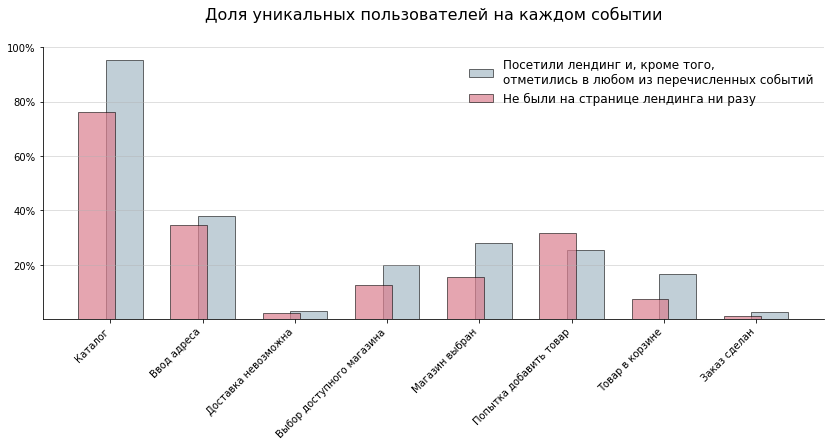

In [33]:
who_visited_trunc_logs = logs[ ~logs.id.isin(never_visited_landing) & (logs.event != 1) ]
who_visited_activity = who_visited_trunc_logs.groupby('event')['id'].nunique() / who_visited_trunc_logs.id.nunique()
who_didnt_activity = (logs[ logs.id.isin(never_visited_landing) ].groupby('event')['id'].nunique() 
                      / len(never_visited_landing))

fig, ax = plt.subplots(figsize = (14, 5))
ax.grid(b = True, axis = 'y', alpha = 0.5)
ax.set_title('Доля уникальных пользователей на каждом событии', fontsize = 16, y = 1.08)
kwargs_barplot = dict(alpha = 0.7, width = 0.4, edgecolor = 'k', linewidth = 0.8)
ax.bar(x = who_visited_activity.index + 0.15, height = who_visited_activity, color = '#a7bbc7', 
       label = 'Посетили лендинг и, кроме того,\nотметились в любом из перечисленных событий', **kwargs_barplot)
ax.bar(x = who_didnt_activity.index - 0.15, height = who_didnt_activity, color = '#da7f8f', 
       label = 'Не были на странице лендинга ни разу', **kwargs_barplot)
ax.set(xticks = who_visited_activity.index, yticks = np.arange(0.2, 1.1, 0.2), 
       yticklabels = ['{:.0%}'.format(x) for x in np.arange(0.2, 1.1, 0.2)])
ax.set_xticklabels(who_visited_activity.index.map(reverse_event_map), rotation = 45, ha = 'right')
ax.legend(loc = 'upper right', fontsize = 'large', frameon = False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('img3.png', bbox_inches = 'tight')
display(fig)
plt.close(fig)

У тех, кто не был на странице лендинга ни разу (на графике рассматриваются вместе как те, кто добавлял товары в корзину, так и те, кто этого не делал), относительно много попыток добавить товар, и они с обычной конверсией попадают на ввод адреса, но затем лишь малая часть из них проходит через выбор магазина, добавление товара и оформление заказа, а значит, они "отваливаются" на вводе адреса. Хочу напомнить, что мы уже очистили данные от тех пользователей, которые добавляли товары в корзину, пропустив этап с проверкой адреса. Это значит, что мы достоверно имеем дело с "отвалившимися". Похоже, что для многих оказывается неприятной неожиданностью, когда всплывающее окно вдруг спрашивает у них адрес.

В нашем случае обе версии сайта работают по одной и той же механике с теми, кто пропустил лендинг - позволяют делать всё, но до тех пор, пока пользователь не захочет пополнить корзину. 
- Во-первых, это следует из дизайна эксперимента (умалчивается о каких-либо особенностях помимо тех, что указаны)
- Во-вторых, я проверил это на своём устройстве (на сайте сейчас стоит тестовая версия).
- Строго говоря, по графику не видно, люди из какой группы теряются между попыткой пополнить корзину и успешным пополнением. Но в эту ситуацию не могут попасть пользователи из тестовой группы, навигация которых началась с лендинга (идея новой версии лендинга в этом и заключается).

In [34]:
group_1_users = set(users.loc[ users['group'] == 1, 'id'].unique())
gr_1_churn_from_add_attempt = (set(logs.query('group == 1 & event == 7')['id'].unique())
                                   .difference(logs.query('group == 1 & event == 8')['id'].unique()))
len_of_susp_churn_gr1 = len(gr_1_churn_from_add_attempt)
print('Пользователей из тестовой группы, которые пытались добавить товар в корзину, но им не удалось:', 
                                                                          len_of_susp_churn_gr1)
gr_1_neither_landing_nor_added_to_cart = gr_1_churn_from_add_attempt.intersection(never_visited_landing)
print('Среди них доля тех, кто ни разу не был на странице лендинга: {:.1%}'
      .format(len(gr_1_neither_landing_nor_added_to_cart) / len_of_susp_churn_gr1))

Пользователей из тестовой группы, которые пытались добавить товар в корзину, но им не удалось: 2202
Среди них доля тех, кто ни разу не был на странице лендинга: 91.2%


Всё это значит, что для пользователей, пропустивших главную страницу, нет никакой разницы, в какой группе они находятся. Если включать их в тест - то всех в контрольную группу. Ведь реализуемый ими сценарий по сути является именно тем, через что проходят пользователи контрольной группы. 
В этой группе, в том числе, окажутся и ранее найденные пользователи

In [35]:
never_visited_landing_gr_1 = group_1_users.intersection(never_visited_landing)

Если мы так сделаем, то в тестовой группе станет на приблизительно на 8000 уникальных пользователей меньше, а в контрольной - на 8000 больше. Нужно ли это? Лучше снизить стандартную ошибку среднего в контрольной группе, чем этого не сделать. Я думаю, что мы ещё оценим, достаточно ли данных, чтобы полагаться на выводы из A/B-теста, и потом решим.

<a id='target8'></a>
### Источник вызова модального окна
[// вернуться к началу](#target100) 

Стоит обратить внимание на ~22% пользователей из группы, где никто не посещал лендинг - те, кто вдобавок не был в каталогах. Дело в том, что, кроме лендинга и каталогов, у нас есть 
- 4 модальных окна, которые не открываются по прямой ссылке
- и два действия, которые недоступны новым пользователям, пропустившим предыдущие окна. 

Это подводит к мысли, что мы опять напали на след "старых" пользователей.

In [36]:
never_visited_catalogs = set(logs['id'].unique()).difference(logs[ logs.event == 2 ]['id'].unique())
skipped_two_pages = never_visited_landing.intersection(never_visited_catalogs)
skipped_two_pages_trunc_logs = logs[ logs.id.isin(skipped_two_pages) ]
skipped_two_pages_trunc_logs = (skipped_two_pages_trunc_logs.groupby('event')['id'].nunique() 
                                / skipped_two_pages_trunc_logs.id.nunique())
skipped_two_pages_trunc_logs = skipped_two_pages_trunc_logs.sort_values(ascending = False).apply('{:.1%}'.format)
skipped_two_pages_trunc_logs = (skipped_two_pages_trunc_logs.set_axis(skipped_two_pages_trunc_logs
                                                              .index.map(reverse_event_map), axis = 0))
print('Их активность (по количеству уникальных пользователей на каждом событии):')
my_display(skipped_two_pages_trunc_logs)

Их активность (по количеству уникальных пользователей на каждом событии):


id
Ввод адреса                88.9%
Попытка добавить товар     84.5%
Выбор доступного магазина  12.5%
Товар в корзине             7.6%
Доставка невозможна         7.2%
Магазин выбран              1.1%
Заказ сделан                0.4%

Не похожи на старых пользователей - их посещения в основном ничем не закончились. В таблицах, где записана история обращений к модальным окнам, есть поле 'source', которое поможет внести ясность и, может быть, даст наводку на другие проблемы в данных. 

In [37]:
print("Значения 'source' в таблице 'typing_address':", ', '.join(typing_address['source'].cat.categories))
print("Значения 'source' в таблице 'shop_selection':", ', '.join(shop_selection['source'].cat.categories))
print("Значения 'source' в таблице 'shop_selected':", ', '.join(shop_selected['source'].cat.categories))

Значения 'source' в таблице 'typing_address': add_alcohol, add_product, address, landing, not_in_delivery_zone
Значения 'source' в таблице 'shop_selection': address_modal, header, landing
Значения 'source' в таблице 'shop_selected': address_modal, header, landing


- **add_alcohol** и **add_product** - варианты для вызова модального окна из каталога магазина (и контрольная, и тестовая группы)
- **landing** - вариант тестовой группы для вызова модального окна
- **not_in_delivery_zone** - если доставка невозможна, то на контрольной версии сайта появляется кнопка 'Выбрать другой адрес'. В тестовой версии этой кнопки нет, поле для ввода адреса не исчезает, и можно сразу ввести новый адрес. Это, кстати - второе различие между тестовой и контрольной версией. Это значит, что те, кто пропустил страницу лендинга, всё-таки имеют дело с разными версиями сайта. Хотя, конечно, далеко не всем из них довелось хоть раз ввести такой адрес, по которому невозможна доставка. Поэтому из найденных недавно восьми тысяч клиентов можно перекинуть в контрольную группу только тех, кто ни разу не вводил адрес, по которому невозможна доставка. Тех, кто вводил, нельзя однозначно рассматривать ни в контексте тестируемой версии сайта, ни в контексте контрольной.

In [38]:
gr_1_passed_invalid_address = logs[ (logs.event == 4) & (logs.group == 1) ]['id'].values
never_visited_landing_gr_1 = never_visited_landing_gr_1.difference(gr_1_passed_invalid_address)

for df in [users, sberm_landing, retailer_main_page, typing_address, address_fail, 
           shop_selection, shop_selected, add_attempt, add_success, orders, logs]:
    df.drop(df[ df.id.isin(gr_1_passed_invalid_address) ].index, axis = 0, inplace = True)

- **address** и **address_modal**. Неясно, что это за опции, но судя по названиям, они как-то связаны.
- **header** - в переводе это либо заголовок, либо "шапка" сайта. При чём здесь они?

In [39]:
logs.reset_index(drop = True, inplace = True)

def previous_acts(df, source_name, action_code, reduce_to = [], ax = False):
    time = df[ df.source == source_name ]['timestamp'].values
    
    # индексы действий с нужным 'source' в таблице 'logs'
    act_idx = logs[ (logs.event == action_code) & (logs['timestamp'].isin(time)) ].index
    
    # так как таблица упорядочена, предыдущие события можно получить, вычтя из вектора индексов единицу.
    # если при смещении индекса мы попали на действия другого пользователя или на давние действия, 
    # то не считаем найденную строчку записью о предыдущем действии
    acts_logs = logs.loc[act_idx, :].reset_index(drop = True)
    prev_acts_logs = logs.loc[act_idx - 1, :].reset_index(drop = True)
    mask = ((acts_logs['id'] == prev_acts_logs['id']) & 
            (acts_logs['timestamp'] - prev_acts_logs['timestamp'] < pd.Timedelta(20, 'm')))
    prev_acts = prev_acts_logs.loc[mask, 'event'].map(reverse_event_map).reset_index()
    
    # отрисовка круговой диаграммы
    pie_chart(prev_acts, 'event', dec = 1, reduce_to = reduce_to, ax = ax,
              title = f"{reverse_event_map[action_code]} (источник '{source_name}')")

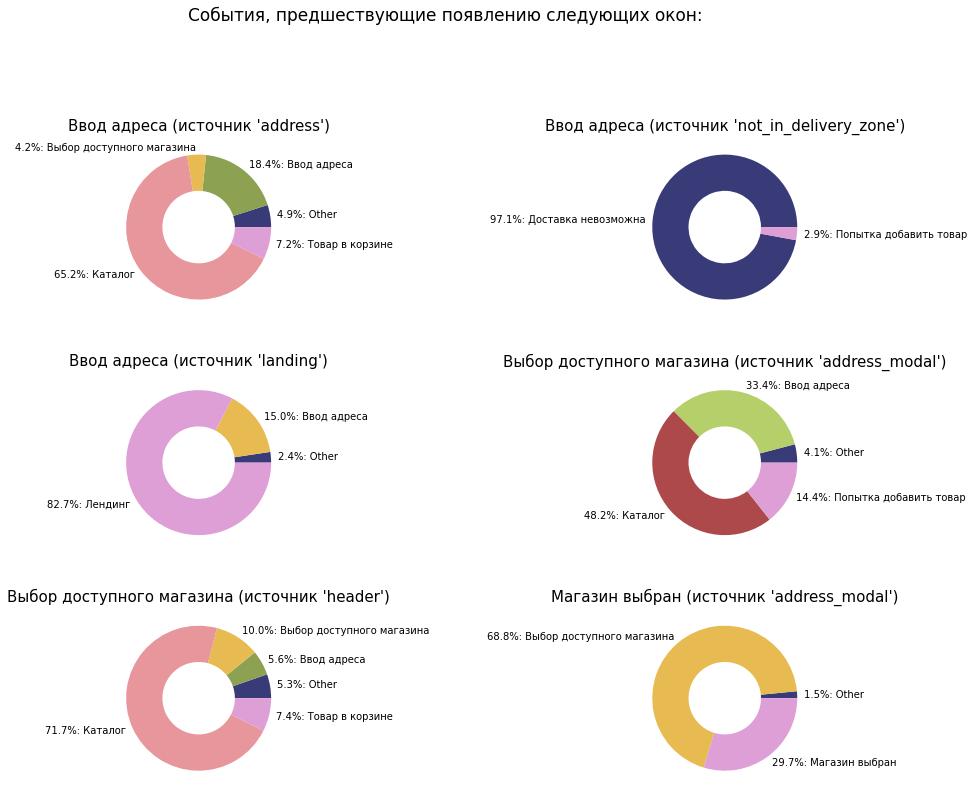

In [40]:
fig = plt.figure(figsize = (18, 12))
grid = fig.add_gridspec(3, 2, wspace = 0.1, hspace = 0.3)
ax1 = fig.add_subplot(grid[0, 0]); ax2 = fig.add_subplot(grid[0, 1]);
ax3 = fig.add_subplot(grid[1, 0]); ax4 = fig.add_subplot(grid[1, 1]);
ax5 = fig.add_subplot(grid[2, 0]); ax6 = fig.add_subplot(grid[2, 1]);
fig.suptitle('События, предшествующие появлению следующих окон:', fontsize = 17, y = 1.03)

previous_acts(typing_address, 'address', 3, reduce_to = ['Каталог', 'Ввод адреса', 
              'Товар в корзине', 'Выбор доступного магазина'], ax = ax1)
previous_acts(typing_address, 'not_in_delivery_zone', 3, ax = ax2)
previous_acts(typing_address, 'landing', 3, reduce_to = ['Лендинг', 'Ввод адреса'], ax = ax3)
previous_acts(shop_selection, 'address_modal', 5, reduce_to = ['Каталог', 'Ввод адреса', 
              'Попытка добавить товар'], ax = ax4)
previous_acts(shop_selection, 'header', 5, reduce_to = ['Каталог', 'Ввод адреса', 
              'Товар в корзине', 'Выбор доступного магазина'], ax = ax5)
previous_acts(shop_selected, 'address_modal', 6, reduce_to = ['Магазин выбран', 'Выбор доступного магазина'], 
              ax = ax6)

plt.savefig('img4.png', bbox_inches = 'tight')
display(fig)
plt.close(fig)

- Графики показывают, что несколько вариантов вызова модальных окон заложено, помимо лендинга и карточек продуктов (о них было упомянуто в дизайне эксперимента), в страницу каталога. Я зашёл на сайт и внимательно рассмотрел страницу каталога. В самом деле, источник 'address', откуда открывается окно ввода адреса - это, по-видимому, то же самое, что источник 'header' для выбора доступного магазина - это две соседние кнопки, расположенные в шапке страницы каталога.
- Запись о проверке адреса дублируется в логах, если по предыдущему адресу доставка невозможна. Тогда источник ('source') новой записи - 'not_in_delivery_zone'. Пользователь из тестовой группы не увидит никаких изменений в модальном окне, но в логах это будут два разных события. Эта деталь могла бы быть существенной, если бы при измерении конверсии мы отталкивались именно от этого события.
- Постоянно имеем от полутора до пяти процентов всех остальных событий в качестве предшествующих. Говорит о том, что нечто постоянно идёт не так, и, следовательно, проблема, скорее всего, не в том, как заскриптованы источники вызова модальных окон. Попытка добавить товар никак не может вызвать окно для ввода адреса по причине 'not_in_delivery_zone' - но в данных такие случаи присутствуют. 
- Записи об открытии модальных окон иногда идут последовательно. Это делается преднамеренно, когда адрес пользователя не проходит проверку. Но нет аналогичной ситуации, к примеру, для выбора магазина. А в данных почти 30% событий "магазин выбран" из источника 'address_modal' следуют за другими "магазин выбран". 9.7% "выборов доступного магазина" из источника 'header' следуют за другими "выборами доступного магазина". И есть подозрение, что если мы посчитаем промежуток времени между ними, то найдём новый артефакт - зачастую он будет аномально коротким. 

In [41]:
# для подтверждения

print("Время между событиями 'Магазин выбран', когда в логах одного пользователя они следуют друг за другом:")
act_idx = logs[ logs.event == 6 ].index
acts_logs = logs.loc[act_idx, :].reset_index(drop = True)
prev_acts_logs = logs.loc[act_idx - 1, :].reset_index(drop = True)
mask = ((acts_logs['id'] == prev_acts_logs['id']) & (prev_acts_logs['event'] == 6))
time_between = acts_logs.loc[mask, 'timestamp'] - prev_acts_logs.loc[mask, 'timestamp']
my_display(time_between.describe())
print(f'Таких задвоенных событий {time_between.shape[0]} пар, или {time_between.shape[0] * 2} строк.')
print(f"При этом строк, фиксирующих событие 'Магазин выбран', во всём датафрейме {len(act_idx)}")

Время между событиями 'Магазин выбран', когда в логах одного пользователя они следуют друг за другом:


timestamp
count                      20742
mean   0 days 00:00:45.885345723
std    0 days 00:54:29.298365381
min              0 days 00:00:00
25%       0 days 00:00:00.009000
50%       0 days 00:00:00.071000
75%       0 days 00:00:01.328750
max       4 days 05:02:50.004000

Таких задвоенных событий 20742 пар, или 41484 строк.
При этом строк, фиксирующих событие 'Магазин выбран', во всём датафрейме 95524


Получается, что пятая часть от всех записей 'Магазин выбран' - это записи, следующие одна за другой с промежутком меньше 133 миллисекунд. Может быть, существуют обстоятельства, при которых компьютер отправляет несколько одинаковых запросов к серверу одновременно. 

Наводку на новые проблемы в данных мы в самом деле получили, но, кажется, что нет смысла погружаться в них глубже - они не помешают (будем считать либо метрики сессий, либо метрики уникальных пользователей, но точно не действия). 

Вернёмся к пользователям, которые не посещали ни лендинг, ни каталог. 84% из них пытались добавить товар, 87% вводили свой адрес, 13% выбирали магазин из нескольких доступных. Из какого источника у них открывался ввод адреса и выбор магазина?

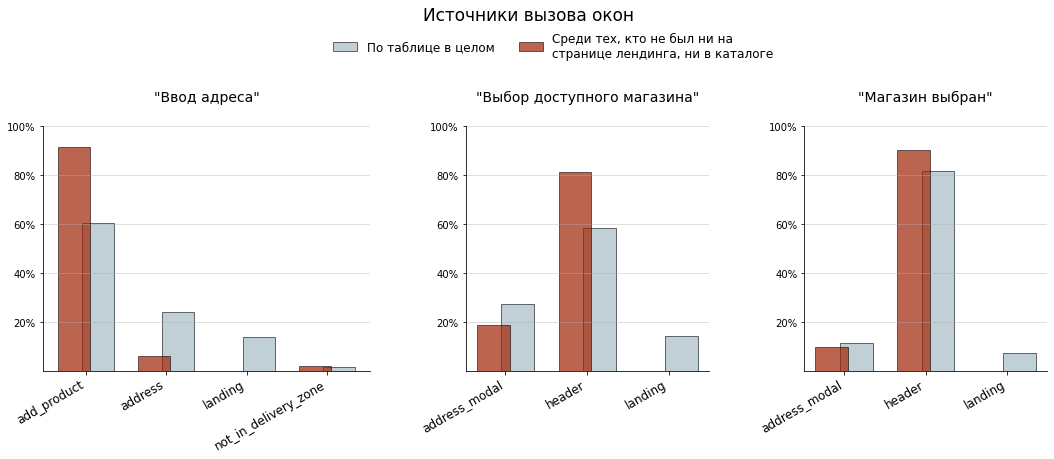

In [42]:
fig = plt.figure(figsize = (18, 4.5))
grid = fig.add_gridspec(1, 12, wspace = 0.15)
fig.add_subplot(grid[0, 0:4]); fig.add_subplot(grid[0, 5:8]); fig.add_subplot(grid[0, 9:12])
fig.suptitle('Иcточники вызова окон', fontsize = 17, y = 1.25)

for df, code, ax in zip([typing_address, shop_selection, shop_selected], [3, 5, 6], fig.axes):
    skipped_ratio = df[ df.id.isin(skipped_two_pages) ]['source'].value_counts(normalize = True).sort_index()
    common_ratio = df['source'].value_counts(normalize = True).sort_index()
    if code == 3:
        skipped_ratio = skipped_ratio.drop(['add_alcohol'])
        common_ratio = common_ratio.drop(['add_alcohol'])
    x_ticks = np.arange(skipped_ratio.shape[0])
    ax.grid(b = True, axis = 'y', alpha = 0.5)
    ax.set_title(f'"{reverse_event_map[code]}"', fontsize = 14, y = 1.08)
    kwargs_barplot = dict(alpha = 0.7, width = 0.4, edgecolor = 'k', linewidth = 0.8)
    ax.bar(x = x_ticks + 0.15, height = common_ratio.values, color = '#a7bbc7', 
           label = 'По таблице в целом', **kwargs_barplot)
    ax.bar(x = x_ticks - 0.15, height = skipped_ratio.values, color = '#9f2305', 
           label = 'Среди тех, кто не был ни на\nстранице лендинга, ни в каталоге', **kwargs_barplot)
    ax.set(xticks = x_ticks, yticks = np.arange(0.2, 1.1, 0.2), 
           yticklabels = ['{:.0%}'.format(x) for x in np.arange(0.2, 1.1, 0.2)])
    ax.set_xticklabels(skipped_ratio.index, rotation = 30, ha = 'right', fontsize = 12)
    if code == 3:
        ax.legend(bbox_to_anchor = (2.265, 1.43), fontsize = 'large', frameon = False, ncol = 2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig('img5.png', bbox_inches = 'tight')
display(fig)
plt.close(fig)

In [43]:
print('История посещений пользователя, который ни разу не был ни на странице лендинга, ни в каталоге:')
random_id = 23858
if random_id in skipped_two_pages:
    random_id_logs = logs[ logs.id == random_id ].copy()
    random_id_logs['source'] = random_id_logs.apply(find_source_for_shop_selected, axis = 1)
    random_id_logs = id_and_event_reverse_map(random_id_logs)
    draw_table(random_id_logs, mode = 'save', colwidths = [0.25, 0.3, 0.25, 0.05, 0.05, 0.1], save_name = 'table2.png')
    display(random_id_logs)

История посещений пользователя, который ни разу не был ни на странице лендинга, ни в каталоге:


timestamp                                    id  \
102724 2020-12-10 10:23:29.450  240e260b-69b4-4585-b72c-c890ae89fc51   
102725 2020-12-10 10:23:30.427  240e260b-69b4-4585-b72c-c890ae89fc51   
102726 2020-12-10 10:23:30.537  240e260b-69b4-4585-b72c-c890ae89fc51   
102727 2020-12-10 10:23:45.804  240e260b-69b4-4585-b72c-c890ae89fc51   
102728 2020-12-10 10:24:35.546  240e260b-69b4-4585-b72c-c890ae89fc51   
102729 2020-12-10 10:24:35.558  240e260b-69b4-4585-b72c-c890ae89fc51   
102730 2020-12-10 10:24:35.612  240e260b-69b4-4585-b72c-c890ae89fc51   
102731 2020-12-10 10:25:09.449  240e260b-69b4-4585-b72c-c890ae89fc51   
102732 2020-12-10 10:25:09.505  240e260b-69b4-4585-b72c-c890ae89fc51   
102733 2020-12-10 10:25:36.829  240e260b-69b4-4585-b72c-c890ae89fc51   
102734 2020-12-10 10:25:37.086  240e260b-69b4-4585-b72c-c890ae89fc51   
102735 2020-12-10 10:25:37.156  240e260b-69b4-4585-b72c-c890ae89fc51   
102736 2020-12-10 10:25:39.300  240e260b-69b4-4585-b72c-c890ae89fc51   

                            event  group  source  
102724  Выбор доступного магазина      0          
102725             Магазин выбран      0  header  
102726             Магазин выбран      0  header  
102727  Выбор доступного магазина      0          
102728             Магазин выбран      0  header  
102729             Магазин выбран      0  header  
102730             Магазин выбран      0  header  
102731             Магазин выбран      0  header  
102732             Магазин выбран      0  header  
102733  Выбор доступного магазина      0          
102734             Магазин выбран      0  header  
102735             Магазин выбран      0  header  
102736             Магазин выбран      0  header

Итак, 97% из них вводили адрес. Больше 90% из них - после попытки добавить товар в корзину, меньше 10% - с помощью кнопки, которая лежит в шапке каталога, т.е. и те, и другие пользовались каталогом. Об использовании каталога говорят источники вызова остальных окон. А ниже, в логах пользователя, видно событие "Магазин выбран" (много раз задвоенное), после которого страница не может не обновиться. Где тогда пропало у каждого из них обращение к каталогу?

Использовать данные этих пользователей найденная проблема не помешает. По-прежнему видно, что они реализуют сценарий контрольной группы. Те из них, кто записан в тестовую группу - уже включены в переменную 'never_visited_landing_gr_1', откуда либо перекинем их в контрольную группу, либо удалим.

<a id='target9'></a>
### Чем могут помочь сессии
[// вернуться к началу](#target100) 

Выяснилось, что пользователь из тестовой группы может успешно пользоваться сервисом так, как будто он из контрольной группы, то есть может избежать всех нововведенией, если ни разу не зайдёт на страницу лендинга. 

Если есть пользователи, которые никогда не посещали лендинг, то найдётся ещё больше тех, кто впервые оказался на странице лендинга не сразу. И проблема, связанная с ними, куда запутаннее, чем с теми, кто на лендинге не был вообще никогда. Последних можно перезаписать в контрольную группу. Но что делать, допустим, в таком случае: пользователь из тестовой группы впервые появился на странице каталога одного из магазинов, с каталога подтвердил адрес и добавил первый товар в корзину (то есть прошёл типичный путь пользователя из контрольной группы), а потом уже зашёл на лендинг, где увидел его новую, тестируемую версию. Если не поправить ситуацию, то успешная конверсия этого пользователя в добавление товара будет записана на счёт тестируемой версии сайта.

Нужно понять, меняется ли поведение пользователей после того, как они посетили лендинг, и зависит ли это от того, в какую экспериментальную группу определён пользователь. Для начала нужно как-то описать тот момент, когда пользователь впервые оказывается на странице лендинга. Для этого разделим действия пользователей на сессии. 

Если с момента последнего действия прошло больше 30 минут, то следующее действие отнесём к следующей сессии. 30 минут - стандартный порог, который используется для той же цели в Я.Аналитике и Google Metrics. Можно отвлечься на звонок друга, можно уйти советоваться с женой, но если прошло больше времени, то человек либо намеренно закончил работу с сайтом, либо окончательно переключился на что-то другое. Это не самое гибкое обобщение. Для более точной аналитики было бы хорошей идеей целенаправленно отслеживать закрытие вкладки и длительное бездействие.

In [44]:
# разделим действия пользователя на сессии

logs['time_passed'] = logs['timestamp'].sub(logs.groupby('id')['timestamp'].shift(1))
first_sessions_acts = (logs[ (logs['time_passed'].isna()) | (logs['time_passed'] > pd.Timedelta(1, 'h')) ])
                    # NaN получается тогда, когда никакого предыдущего действия нет
                    # Поэтому пропуски включаем и нумеруем как первую сессию.
logs['time_passed'] = first_sessions_acts.groupby('id')['id'].rank(method = 'first')

# к каждому событию добавляется номер сессии
logs['time_passed'] = logs['time_passed'].fillna(method = 'ffill').astype('int')
logs = logs.rename({'time_passed': 'session'}, axis = 1)

Пользователей можно разбить по принципу когортного анализа - в зависимости от того, на которой по счёту сессии они впервые оказались на странице лендинга. Для каждой "когорты" и каждой группы (имеются в виду контрольная и тестовая группы) мы посчитаем две метрики:
1. Долю "кривых сценариев" (когда попытка добавить товар в корзину не закончилась успешно)
2. Конверсию из сессии в добавление товаров в корзину

In [45]:
def session_metrics(array):
    x = list(array)
    return (7 in x) & (8 not in x), (8 in x)
scenarios_by_sessions = logs.groupby(['id', 'session'])['event'].apply(session_metrics).reset_index()
# первым элементом функия возвращает значение True или False в зависимости от того, имел ли место "кривой сценарий".
# вторым элементом - добавил ли пользователь хоть один товар в корзину за данную сессию

scenarios_by_sessions['tried_but_failed'] = scenarios_by_sessions['event'].apply(lambda x: x[0])
scenarios_by_sessions['tried_and_succeded'] = scenarios_by_sessions['event'].apply(lambda x: x[1])
scenarios_by_sessions.drop(['event'], axis = 1, inplace = True)

# номер сессии, когда пользователь в первый раз побывал на странице лендинга и код группы.
# т.к. это inner join, будут исключены те пользователи, которые не были на лендинге ни разу
temp = (logs[ logs.event == 1 ].groupby('id').agg({'group': 'first', 'session': 'min'}).reset_index()
                                                  .rename({'session': 'first_time_on_landing'}, axis = 1))
scenarios_by_sessions = scenarios_by_sessions.merge(temp, on = 'id')

# количество сессий для каждого пользователя
temp = logs.groupby('id')['session'].max().reset_index().rename({'session': 'sessions_cnt'}, axis = 1)
scenarios_by_sessions = scenarios_by_sessions.merge(temp, on = 'id')
display(scenarios_by_sessions.sample(4, random_state = 6))

id  session  tried_but_failed  tried_and_succeded  group  \
115247  204558        1             False                True      0   
118640  212288        1             False               False      0   
76079   123737        2             False                True      0   
164307  326683        1             False               False      0   

        first_time_on_landing  sessions_cnt  
115247                      1             1  
118640                      1             1  
76079                       1             2  
164307                      1             1

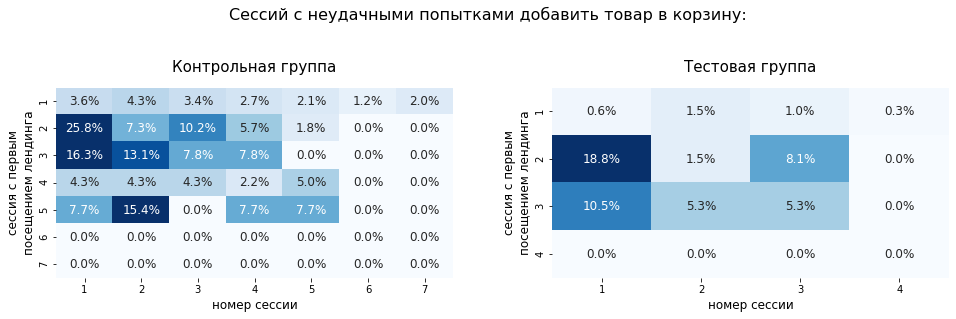

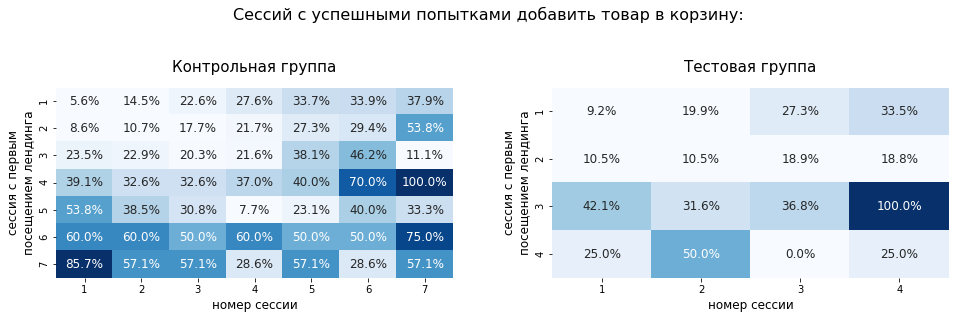

In [46]:
def heatmap(group, key_col, ax):
    pivot = (scenarios_by_sessions.query('group == @group').pivot_table(index = 'first_time_on_landing', 
                                                  columns = 'session', values = key_col, aggfunc = 'mean'))
    limit = 7 if group == 0 else 4
    pivot = pivot.iloc[:limit, :limit]
    if key_col == 'tried_but_failed':
        vmin = 0; vmax = 0.15
    else:
        vmin = 0.2; vmax = 0.8
    sns.heatmap(pivot, annot = True, annot_kws = {'fontsize': 'large'}, cmap = 'Blues', fmt = '.1%', 
                ax = ax, cbar = False, vmin = vmin, vmax = vmax)
    ax.set_xlabel('номер сессии', fontsize = 12)
    ax.set_ylabel('сессия с первым\nпосещением лендинга', fontsize = 12)
    
    
fig1, ax1, ax2 = two_subplots((16, 3.5), '', ['Контрольная группа', 
                                             'Тестовая группа'])
fig1.suptitle('Сессий с неудачными попытками добавить товар в корзину:', y = 1.2, fontsize = 16)
heatmap(0, 'tried_but_failed', ax1)
heatmap(1, 'tried_but_failed', ax2)
plt.savefig('img6.png', bbox_inches = 'tight')

fig2, ax3, ax4 = two_subplots((16, 3.5), '', ['Контрольная группа', 
                                             'Тестовая группа'])
fig2.suptitle('Сессий с успешными попытками добавить товар в корзину:', y = 1.2, fontsize = 16)
heatmap(0, 'tried_and_succeded', ax3)
heatmap(1, 'tried_and_succeded', ax4)
plt.savefig('img7.png', bbox_inches = 'tight')

display(fig1)
print('\n')
display(fig2)
plt.close(fig1)
plt.close(fig2)

- Доля неудачных сценариев в первых сессиях тестовой группы, когда в рамках той же сессии пользователь заходил на лендинг - 0.6%. Это контринтуитивно - если пользователь сразу попал на тестируемую версию лендинга, то он не мог совершить неудачную попытку добавления товара. Наверное, он в рамках одной сессии сначала пытался добавить товар из каталога, а потом зашёл на лендинг (или наоборот). Проверим.

In [47]:
query = 'session == 1 & first_time_on_landing == 1 & tried_but_failed == True & group == 1'
example = 414986
if example in scenarios_by_sessions.query(query)['id'].unique():
    as_example = logs[ logs.id == example ].copy()
    as_example['source'] = as_example.apply(find_source_for_address_window, axis = 1)
    ax_example = id_and_event_reverse_map(as_example)
    draw_table(ax_example, mode = 'save', colwidths = [0.25, 0.3, 0.25, 0.05, 0.05, 0.1], save_name = 'table3.png')
    display(ax_example)

timestamp                                    id  \
1404022 2020-11-29 05:46:31.159  2a57cde4-2b33-49ce-947d-c653823df63b   
1404023 2020-11-29 05:46:31.887  2a57cde4-2b33-49ce-947d-c653823df63b   
1404024 2020-11-29 06:12:31.281  2a57cde4-2b33-49ce-947d-c653823df63b   
1404025 2020-11-29 06:12:33.147  2a57cde4-2b33-49ce-947d-c653823df63b   
1404026 2020-11-29 06:12:33.189  2a57cde4-2b33-49ce-947d-c653823df63b   
1404027 2020-11-29 06:12:36.592  2a57cde4-2b33-49ce-947d-c653823df63b   
1404028 2020-11-29 06:13:01.021  2a57cde4-2b33-49ce-947d-c653823df63b   
1404029 2020-11-29 06:13:07.787  2a57cde4-2b33-49ce-947d-c653823df63b   
1404030 2020-11-29 06:13:21.451  2a57cde4-2b33-49ce-947d-c653823df63b   

                             event  group  session   source  
1404022                    Лендинг      1        1           
1404023                Ввод адреса      1        1  landing  
1404024  Выбор доступного магазина      1        1           
1404025             Магазин выбран      1        1           
1404026             Магазин выбран      1        1           
1404027                    Каталог      1        1           
1404028     Попытка добавить товар      1        1           
1404029                    Каталог      1        1           
1404030     Попытка добавить товар      1        1

... Видно, не всегда. Это - некоторая необъяснимая неудача. Встаёт вопрос классификации: можно ли расценивать историю этого пользователя как неудачу тестовой версии? А как расценивать историю тех, кто, несмотря на то, что зачислен в тестовую группу, сумел пробраться в каталог попробовал добавить товар, спровоцировав появление окна для ввода адреса, и после этого ушёл и больше не возвращался. Решим чуть позже, пока что продолжим изучать тепловую карту.
- Если о пользователе известно, что он на протяжении многих сессий не заходил на лендинг, то, скорее всего, он уже давно со всем разобрался и успешно пользуется сервисом. В когортах '4', '5', '6', '7' и '8' в контрольной группе и в когорте '4' в тестовой группе (в тестовой группе меньше пользователей, поэтому для неё удалось сформировать меньше когорт) в первые несколько сессий доля неудачных сценариев значительно ниже, а целевых действий - значительно выше, чем у пользователей, которые в первый раз зашли на лендинг раньше. Это позволяет выделить, помимо старых пользователей, ещё одну группу, из-за которой вновь встаёт вопрос об однородности экспериментальных групп. Если распределение между группами "продвинутых" пользователей, которым лендинг настолько не нужен, что в первый раз они посетили его после четвёртой сессии, хоть незначительно сдвинуто, то с их помощью конверсия в целевое действие в одной группе будет неоправданно завышено. Я веду к тому, что мы сделаем лучше, если будем тестировать нововведения без них. Развивая логику, к "продвинутым" также следует причислить тех, кто ни разу не посещал лендинг, совершив при этом больше четырёх сессий.

In [48]:
progressive_users_1 = scenarios_by_sessions.query('first_time_on_landing >= 4')['id'].unique()
temp = logs[ logs.id.isin(never_visited_landing) ].groupby('id')['session'].max()
progressive_users_2 = temp[ temp >= 4 ].index
progressive_users = np.concatenate([progressive_users_1, progressive_users_2])
pr_ratio = '{:.2%}'.format(len(progressive_users) / logs.id.nunique())
print(f'Продвинутых пользователей в эксперименте {len(progressive_users)}, или {pr_ratio} от общего числа')
logs = logs[ ~logs.id.isin(progressive_users) ]
users = users[ ~users.id.isin(progressive_users) ]
print('Удалили')

# ещё раз корректируем список тех id, которые готовимся переместить в контрольную группу
never_visited_landing_gr_1 = never_visited_landing_gr_1.difference(progressive_users)

Продвинутых пользователей в эксперименте 997, или 0.38% от общего числа
Удалили


- Есть один артефакт - большая доля первых сессий с неудачными сценариями у тех, кто впервые зашёл на страницу лендинга во вторую сессию.

In [49]:
as_example = scenarios_by_sessions.query('session == 1 & first_time_on_landing == 2 & tried_but_failed == True')
as_example = as_example.sample(1, random_state = 1)['id']
as_example = logs[ logs.id.isin(as_example) ].copy()
as_example['source'] = as_example.apply(find_source_for_address_window, axis = 1)
as_example = id_and_event_reverse_map(as_example)
draw_table(as_example, mode = 'save', colwidths = [0.25, 0.3, 0.25, 0.05, 0.05, 0.1], save_name = 'table4.png')
display(as_example)

timestamp                                    id  \
1279750 2020-12-01 16:19:25.824  fee25a55-4954-4054-b311-87e10620d1ce   
1279751 2020-12-01 16:19:25.839  fee25a55-4954-4054-b311-87e10620d1ce   
1279752 2020-12-01 16:19:55.296  fee25a55-4954-4054-b311-87e10620d1ce   
1279753 2020-12-01 16:19:55.310  fee25a55-4954-4054-b311-87e10620d1ce   
1279754 2020-12-01 16:20:08.011  fee25a55-4954-4054-b311-87e10620d1ce   
1279755 2020-12-11 11:38:40.772  fee25a55-4954-4054-b311-87e10620d1ce   
1279756 2020-12-11 11:38:52.446  fee25a55-4954-4054-b311-87e10620d1ce   
1279757 2020-12-11 13:38:07.216  fee25a55-4954-4054-b311-87e10620d1ce   
1279758 2020-12-11 13:38:07.217  fee25a55-4954-4054-b311-87e10620d1ce   
1279759 2020-12-11 13:38:38.635  fee25a55-4954-4054-b311-87e10620d1ce   
1279760 2020-12-11 13:38:48.618  fee25a55-4954-4054-b311-87e10620d1ce   
1279761 2020-12-11 13:38:49.856  fee25a55-4954-4054-b311-87e10620d1ce   
1279762 2020-12-11 13:46:41.371  fee25a55-4954-4054-b311-87e10620d1ce   

                          event  group  session       source  
1279750  Попытка добавить товар      0        1               
1279751             Ввод адреса      0        1  add_product  
1279752  Попытка добавить товар      0        1               
1279753             Ввод адреса      0        1  add_product  
1279754  Попытка добавить товар      0        1               
1279755                 Лендинг      0        2               
1279756                 Каталог      0        2               
1279757  Попытка добавить товар      0        3               
1279758             Ввод адреса      0        3  add_product  
1279759  Попытка добавить товар      0        3               
1279760  Попытка добавить товар      0        3               
1279761         Товар в корзине      0        3               
1279762                 Каталог      0        3

Если пользователь, зайдя на сайт в первый раз, не разобрался с тем, как добавить товар со страницы каталога, то есть повышенная вероятность того, что следующую сессию он начнёт с начальной страницы, а не с каталога. Это объяснимо. Именно это и видно в логах - человеку не удалось добавить товар из каталога. Спустя некоторое время он вернулся, открыл начальную страницу (лендинг) и прошёл всю воронку вплоть до целевого действия.
- Подводя итог тепловым картам. Тестируемая страница лендинга, кажется, предохраняет от части неудачных попыток добавить товар, но ничего не гарантирует. Для нас это значит, что формулы конверсии не могут быть одинаковыми для тестовой и контрольной групп, потому что так мы смешаем в тестовой группе конверсию тех, кому помогла тестируемая фича с конверсией тех, кто пришёл к целевому действию каким-то другим путём. 

Если при подсчёте какой-либо конверсии отталкиваться от числа сессий, когда некоторое событие имело (или не имело) место, то зачастую будем считывать сразу по нескольку сигналов с одного человека. Если пользователь совершает 15 сессий, каждая из которых содержит только посещения лендинга (а это реальный кейс из наших данных), то мы получим 15 "отказов" из 15 сессий. Но это не то. К метрикам сессий можно будет вернуться, если нам не будет хватать размера выборок, но вообще-то задача предополагает 'user-centric' подход: считать не отказные сессии, а отказавшихся пользователей.

Крупные сайты часто страдают от ботов. В этом датасете ботов можно обнаружить по четырём признакам - количество сессий, среднее количество действий за сессию, длительность сессий и среднее время между действиями. 

In [50]:
# перезапишем переменную users - включим известные характеристики пользователей, добавим характеристики его сессий 

sessions = logs.groupby(['id', 'session'])['timestamp'].agg(['min', 'max', 'count']).reset_index()
sessions['duration_m'] = sessions['max'].sub(sessions['min']) / np.timedelta64(1, 'm')
sessions.drop(['min', 'max'], axis = 1, inplace = True)
sessions = sessions.groupby('id').agg({'count': 'mean', 'session': 'max', 'duration_m': 'mean'}).reset_index()
            # нарочно средняя длительность, а не медиана. аггрегируем данные не для выборки пользователей, 
            # а для каждого пользователя по отдельности. поэтому выбросы, если есть, не портят картину
users = users.groupby('id')[['group', 'device_type']].first().merge(sessions, on = 'id')
users = users.rename({'session': 'sessions_cnt', 'count': 'actions_per_session', 
                      'duration_m': 'mean_duration'}, axis = 1)
users['time_between_actions'] = users['mean_duration'].div(users['actions_per_session'])

X = users.iloc[:, 3:7]
# пусть мы ищем одного бота на десять тысяч пользователей.
prediction = IsolationForest(random_state = 0, contamination = 0.0001).fit_predict(X)
display(users[ prediction < -0.5 ].iloc[:, 3:7].describe())

actions_per_session  sessions_cnt  mean_duration  time_between_actions
count            26.000000     26.000000      26.000000             26.000000
mean            119.334134      4.192308     166.220213              1.965869
std              82.023393      3.633392      97.336109              2.695896
min               4.222222      1.000000      63.200311              0.709404
25%              61.781250      1.000000      82.415082              1.172490
50%             126.000000      3.000000     143.526901              1.348631
75%             137.833333      7.000000     228.536342              1.754458
max             449.000000     12.000000     415.933033             14.968495

Кажется, лес просто поймал активных пользователей. Посмотрим, все ли они добавляли товары - боты не будут вводить адрес и выбирать магазин.

In [51]:
active_but_didnt_add_anything = (set(users[ prediction < -0.5 ]['id'].unique())
                                     .difference(add_success['id'].unique()))
print('Среди подозрительно активных пользователей число тех, кто не добавил ни одного товара - '
      f'{len(active_but_didnt_add_anything)} человек.')

Среди подозрительно активных пользователей число тех, кто не добавил ни одного товара - 1 человек.


In [52]:
display(logs[ logs.id.isin(active_but_didnt_add_anything) ])

timestamp      id  event  group  session
286911 2020-12-02 09:28:12.641  106605      1      0        1
286912 2020-12-02 09:30:10.066  106605      2      0        1
286913 2020-12-02 09:30:29.473  106605      5      0        1
286914 2020-12-02 09:30:30.510  106605      6      0        1
286915 2020-12-02 09:30:43.144  106605      2      0        1
286916 2020-12-02 09:32:32.088  106605      2      0        1
286917 2020-12-02 09:32:52.518  106605      1      0        1
286918 2020-12-02 09:33:12.871  106605      1      0        1
286919 2020-12-02 09:33:35.227  106605      1      0        1
286920 2020-12-02 09:33:55.609  106605      2      0        1
286921 2020-12-02 09:34:20.315  106605      1      0        1
286922 2020-12-02 09:34:32.164  106605      2      0        1
286923 2020-12-02 14:17:27.973  106605      1      0        2
286924 2020-12-02 14:35:37.062  106605      1      0        2
286925 2020-12-02 14:47:28.631  106605      1      0        2
286926 2020-12-02 15:11:07.743  106605      1      0        2
286927 2020-12-02 16:41:31.103  106605      1      0        3
286928 2020-12-02 16:42:02.658  106605      2      0        3
286929 2020-12-02 17:07:48.876  106605      1      0        3
286930 2020-12-02 17:33:44.141  106605      1      0        3
286931 2020-12-03 01:55:52.340  106605      1      0        4
286932 2020-12-03 04:37:43.405  106605      1      0        5
286933 2020-12-03 06:01:03.353  106605      1      0        6
286934 2020-12-03 07:03:01.524  106605      1      0        7
286935 2020-12-03 07:52:26.379  106605      1      0        7
286936 2020-12-03 08:09:58.688  106605      1      0        7
286937 2020-12-03 08:33:09.691  106605      1      0        7
286938 2020-12-03 09:28:53.714  106605      1      0        7
286939 2020-12-03 10:47:05.833  106605      1      0        8
286940 2020-12-03 11:04:03.566  106605      1      0        8
286941 2020-12-03 12:04:01.400  106605      1      0        8
286942 2020-12-03 12:44:18.951  106605      1      0        8
286943 2020-12-03 14:26:57.389  106605      1      0        9
286944 2020-12-03 14:48:42.744  106605      1      0        9
286945 2020-12-03 15:23:05.461  106605      1      0        9
286946 2020-12-03 16:12:22.263  106605      1      0        9
286947 2020-12-03 17:06:08.398  106605      1      0        9
286948 2020-12-03 17:40:27.918  106605      1      0        9

Здесь всё нормально.

<a id='target10'></a>
### Формулировка метрик
[// вернуться к началу](#target100) 

**Bounce Rate**

Считать не отказные сессии, а отказавшихся из-за лендинга пользователей. Знаменатель формулы - все пользователи, первая сессия которых содержит посещение лендинга. Если пользователь из тестовой группы, и первая сессия содержит вызов модальных окон, то хотя бы одно из них должно иметь источник 'landing' (иначе трудно утверждать, что лендинг оказал хоть какой-то эффект на его поведение). Числитель - те из них, кто на момент окончания эксперимента ни разу не совершил никакого действия, которое отличалось бы от посещения лендинга. 


**Конверсия из активности на сайте в добавление товара в корзину**

Можно подумать, что удачный способ посчитать эту метрику -  отслеживать конверсию тех, кто хотя бы раз вводил адрес. Но ввод адреса в группе А - это попытка пользователя добавить товар в корзину, когда он уже заряжен на покупку.  Количество "успехов" тогда будет зависеть от количества "попыток". Для контрольной группы активностью лучше назвать любое действие (помимо посещения лендинга), которое пользователь совершил на сайте. Напротив, у тестовой группы в знаменателе конверсии будут пользователи, которые хотя бы раз вызывали окно ввода адреса из источника 'landing'. Если все вызовы окна ввода адреса происходили из другого источника, значит, пользователь так и не воспользовался тестируемым интерфейсом. Исход для такого пользователя трудно однозначно расценить как ноль или как единицу ("успех" или "неудачу" тестовой версии сайта). А в числителе для тестовой группы будут те из них, кто совершил два действия: хотя бы раз выбрал магазин (через модального окно) из источника 'landing' и хотя бы раз добавил товар в корзину. Фильтр по первому действию позволит засчитать в качестве "неудачи" те случаи, когда пользователи начали вводить адрес с источника 'landing', но не закончили, а потом вернулись через каталог, и через него прошли весь путь вплоть до целевого действия (или когда это происходило в обратном порядке).

In [53]:
# удаляем не только тех, кто из тестовой группы не был на странице лендинга (кого мы готовили к этому), но из
# контрольной группы тоже. неохота перекашивать не до конца ясное распределение пользователей по группам
print(f'Удаляем данные {len(never_visited_landing)} пользователей, которые ни разу не посещали лендинг')
for df in [users, sberm_landing, retailer_main_page, typing_address, address_fail, 
           shop_selection, shop_selected, add_attempt, add_success, orders, logs]:
    df.drop(df[ df.id.isin(never_visited_landing) ].index, axis = 0, inplace = True)
group_1_users = set(users.loc[ users['group'] == 1, 'id'].unique())

Удаляем данные 73460 пользователей, которые ни разу не посещали лендинг


Метрика Bounce по пользователям.

In [54]:
# функция, которая получает датафрейм с полем 'source' и проверяет, какие id из имеющегося списка 
# в свою первую сессию имели запись со значием 'landing' в поле 'source'. возвращает список id
def ids_with_acts_from_landing_source_in_1_sess(df):
    max_time_for_1_sess = (logs[ logs.id.isin(pre_trials_b_gr1) & (logs.session == 1) ]
                                 .groupby('id')['timestamp'].max().reset_index())
    df_landing_gr1 = (df[ df.id.isin(pre_trials_b_gr1) & (df.source == 'landing') ])
    df_landing_gr1 = df_landing_gr1.merge(max_time_for_1_sess, on = 'id', suffixes=('', '_max'))
    return df_landing_gr1.query('timestamp_max > timestamp')['id'].unique()

# логи тех, кто посещал лендинг в первую сессию
visited_landing_in_1_sess = logs.query('event == 1 & session == 1')

# знаменатель и числитель bounce rate для контрольной группы (A)
trials_b_gr0 = visited_landing_in_1_sess.query('group == 0')['id'].unique()
passed_the_landing_gr0 = logs[ logs.id.isin(trials_b_gr0) & (logs.event != 1) ]['id'].unique()

# пользователи из B, в первую сессию открывавшие лендинг
pre_trials_b_gr1 = set(visited_landing_in_1_sess.query('group == 1')['id'].unique())
# пользователи из B, которые в первую сессию посещали лендинг и открывали модальные окна
landing_and_modals_gr1 = (logs[ logs.id.isin(pre_trials_b_gr1) & (logs.session == 1) & logs.event.isin([3, 5, 6]) ]
                              .id.unique())
# пользователи из B, которые в первую сессию открывали какие-либо модальные окна из источника 'landing'
trials_b_shop_selected = ids_with_acts_from_landing_source_in_1_sess(shop_selected)
trials_b_typing_address = ids_with_acts_from_landing_source_in_1_sess(typing_address)
trials_b_shop_selection = ids_with_acts_from_landing_source_in_1_sess(shop_selection)
modals_from_landing_source = set(trials_b_shop_selected).union(trials_b_typing_address, trials_b_shop_selection)
# пользователи из B, которые в первую сессию посещали лендинг и открывали модальные окна, но ни одного - из 
# из источника 'landing'
modals_from_elsewhere = set(landing_and_modals_gr1).difference(modals_from_landing_source)
trials_b_gr1 = list(pre_trials_b_gr1.difference(modals_from_elsewhere))
passed_the_landing_gr1 = logs[ logs.id.isin(trials_b_gr1) & (logs.event != 1) ]['id'].unique()

Конверсия в добавление товаров в корзину по пользователям.

In [55]:
# пользователи из B, которые хоть раз вызывали модельное окно из источника 'landing'
at_least_one_shop_selected_from_landing_gr1 = (shop_selected[ (shop_selected.id.isin(group_1_users)) & 
                                                              (shop_selected.source == 'landing') ]['id'].unique())
at_least_one_address_typed_from_landing_gr1 = (typing_address[ (typing_address.id.isin(group_1_users)) & 
                                                               (typing_address.source == 'landing') ]['id'].unique())

# пользователи из B, которые хоть раз вызывали модельное окно из источника 'landing' - это trials.
trials_c_gr1 = list(group_1_users.intersection(at_least_one_address_typed_from_landing_gr1))

# те из них, кто, во-первых, хотя бы раз добавил товар в корзину и, во-вторых, хотя бы раз 
# выбрал магазин в окне из источника 'landing'
passed_the_funnel_gr1 = set(passed_the_funnel).intersection(at_least_one_shop_selected_from_landing_gr1, trials_c_gr1)


# Пользователи из А, которые проявляли активность помимо просмотра лендинга и каталога ('trials_c_gr0')
# и которые хотя бы раз добавляли товар в корзину ('passed_the_funnel_gr0')
trials_c_gr0 = logs[ (logs.event != 1) & (logs.group == 0) ]['id'].unique()
passed_the_funnel_gr0 = set(passed_the_funnel).intersection(logs.loc[ logs.group == 0, 'id' ].unique())

In [56]:
bounce_gr1 = 1 - len(passed_the_landing_gr1) / len(trials_b_gr1)
bounce_gr0 = 1 - len(passed_the_landing_gr0) / len(trials_b_gr0)

conv_to_add_gr1 = len(passed_the_funnel_gr1) / len(trials_c_gr1)
conv_to_add_gr0 = len(passed_the_funnel_gr0) / len(trials_c_gr0)


print('Bounce Rate')
print('{: <35}'.format('   - текущей версии лендинга: '), 
      '{:.2%}'.format(bounce_gr0))
print('{: <35}'.format('   - тестовой версии лендинга: '), 
      '{:.2%}'.format(bounce_gr1))
print('{: <35}'.format('     Размер групп: '), 
      f'{len(trials_b_gr0)} / {len(trials_b_gr1)}')
print('\nКонверсия из активности\nв добавление товара в корзину') 
print('{: <35}'.format('   - при текущей версии лендинга: '), 
      '{:.2%}'.format(conv_to_add_gr0))
print('{: <35}'.format('   - при тестовой версии лендинга: '), 
      '{:.2%}'.format(conv_to_add_gr1))
print('{: <35}'.format('     Размер групп: '), 
      f'{len(trials_c_gr0)} / {len(trials_c_gr1)}')

Bounce Rate
   - текущей версии лендинга:       58.84%
   - тестовой версии лендинга:      64.93%
     Размер групп:                  165479 / 18489

Конверсия из активности
в добавление товара в корзину
   - при текущей версии лендинга:   15.46%
   - при тестовой версии лендинга:  19.83%
     Размер групп:                  69365 / 7614


В очищенном от шума сигнале разница между группами намного более выражена. 
Нужно создать сводную таблицу с информацией о каждом пользователе.

In [57]:
users = users.set_index('id')

# дополним таблицу users значениями метрик
# кто в течение первой сессии хоть раз был на странице лендинга
users.loc[ np.concatenate([trials_b_gr0, trials_b_gr1]), 'started_from_landing' ] = 1
users.loc[ np.concatenate([passed_the_landing_gr0, passed_the_landing_gr1]), 'bounced_from_landing' ] = 0

# кто хотя бы раз успешно клал товар в корзину - напротив того ставим единицу
users.loc[ np.concatenate([trials_c_gr0, trials_c_gr1]), 'activity_aside_landing' ] = 1
passed_the_funnel_all_gr = np.concatenate([list(passed_the_funnel_gr0), list(passed_the_funnel_gr1)])
users.loc[ passed_the_funnel_all_gr, 'target_action_done' ] = 1

gc.collect()
users['bounced_from_landing'] = users['bounced_from_landing'].fillna(1)
users.iloc[:, -4:] = users.iloc[:, -4:].fillna(0).astype('int')

In [58]:
no_match = users.query('activity_aside_landing == 0 & started_from_landing == 0')
print('Не подошли под формулировки обеих метрик', no_match.shape[0], 'пользователей из следующих групп:')
my_display(no_match['group'].value_counts(), 
           index_name = 'Код группы', col_names = ['Кол-во пользователей'])
random_id = 319876
if random_id in no_match.index:
    random_id_logs = logs[ logs.id == random_id  ].iloc[:14, :].copy()
    random_id_logs['source'] = random_id_logs.apply(find_source_for_address_window, axis = 1)
    random_id_logs = id_and_event_reverse_map(random_id_logs)
    draw_table(random_id_logs, mode = 'save', colwidths = [0.25, 0.3, 0.25, 0.05, 0.05, 0.1], 
               save_name = 'table5.png')
    print('\nНетрудно убедиться, что это те пользователи из тестовой группы, которые '
          'не пользовались тестируемым интерфейсом\nК примеру,')
    display(random_id_logs)

logs = logs[ ~logs.id.isin(no_match.index) ]
users = users.drop(no_match.index)

Не подошли под формулировки обеих метрик 623 пользователей из следующих групп:


Кол-во пользователей
Код группы                      
1                            623


Нетрудно убедиться, что это те пользователи из тестовой группы, которые не пользовались тестируемым интерфейсом
К примеру,


timestamp                                    id  \
1073526 2020-12-04 08:52:27.857  01ca9617-2b62-4488-921b-2de58f54322e   
1073527 2020-12-04 08:52:35.177  01ca9617-2b62-4488-921b-2de58f54322e   
1073528 2020-12-04 08:52:45.789  01ca9617-2b62-4488-921b-2de58f54322e   
1073529 2020-12-04 08:52:57.005  01ca9617-2b62-4488-921b-2de58f54322e   
1073530 2020-12-04 08:53:02.068  01ca9617-2b62-4488-921b-2de58f54322e   
1073531 2020-12-04 08:53:06.271  01ca9617-2b62-4488-921b-2de58f54322e   
1073532 2020-12-04 08:53:39.978  01ca9617-2b62-4488-921b-2de58f54322e   
1073533 2020-12-04 08:53:43.490  01ca9617-2b62-4488-921b-2de58f54322e   
1073534 2020-12-04 08:55:55.766  01ca9617-2b62-4488-921b-2de58f54322e   
1073535 2020-12-04 08:55:59.989  01ca9617-2b62-4488-921b-2de58f54322e   
1073536 2020-12-04 09:05:08.192  01ca9617-2b62-4488-921b-2de58f54322e   
1073537 2020-12-04 09:05:11.614  01ca9617-2b62-4488-921b-2de58f54322e   
1073538 2020-12-04 09:05:17.032  01ca9617-2b62-4488-921b-2de58f54322e   
1073539 2020-12-04 09:05:18.602  01ca9617-2b62-4488-921b-2de58f54322e   

                          event  group  session   source  
1073526                 Лендинг      1        1           
1073527                 Каталог      1        1           
1073528             Ввод адреса      1        1  address  
1073529                 Каталог      1        1           
1073530          Магазин выбран      1        1           
1073531                 Каталог      1        1           
1073532          Магазин выбран      1        1           
1073533                 Каталог      1        1           
1073534          Магазин выбран      1        1           
1073535                 Каталог      1        1           
1073536          Магазин выбран      1        1           
1073537                 Каталог      1        1           
1073538  Попытка добавить товар      1        1           
1073539         Товар в корзине      1        1

Чтобы с пользой визуализировать течение эксперимента, нужно знать дату, когда с каждым пользователем прозошёл некоторый исход, притом здесь важно не то, когда пользователь отвалился окончательно (сделал последнее действие), а когда он перестал продвигаться по воронке. Важно найти такой момент, когда для каждого пользователя - либо отказ или успех. Если мы будем считать успехом первый раз, когда пользователь ушёл дальше лендинга, а отказом - последний раз, когда он зашёл на лендинг, то на двухнедельном промежутке мы получим убывающий тренд, а убывающий тренд может ввести в заблуждение (даже если при этом разница между метриками в группах будет одинаковой).

Датой успехов и отказов с лендинга будет дата первого посещения лендинга.
Датой успехов и отказов добавления в корзину - дата первого добавления для успехов или дата первой, помимо лендинга, активности для неудачи.

In [59]:
bounce_timestamps = (logs[ logs.id.isin(users.query('started_from_landing == 1 & bounced_from_landing == 1').index) ]
                    .groupby('id')['timestamp'].min()).reset_index()
ctr_timestamps = (logs[ logs.id.isin(users.query('started_from_landing == 1 & bounced_from_landing == 0').index) 
                       & (logs.session == 1) ].groupby('id')['timestamp'].min().reset_index())

target_acts_timestamps = (logs[ logs.id.isin(passed_the_funnel_all_gr) & (logs.event == 8) ]
                                .groupby('id')['timestamp'].min().reset_index())
no_target_acts_ids = users.query('activity_aside_landing == 1 & target_action_done == 0').index
no_target_acts_timestamps = (logs[ logs.id.isin(no_target_acts_ids) & (logs.event != 1) ]
                             .groupby('id')['timestamp'].min().reset_index())

users = users.reset_index()
users = (users.merge(no_target_acts_timestamps.append(target_acts_timestamps), on = 'id', how = 'left')
              .rename({'timestamp': 'conversion_timestamp'}, axis = 1))
users = (users.merge(bounce_timestamps.append(ctr_timestamps), on = 'id', how = 'left')
              .rename({'timestamp': 'bounce_timestamp'}, axis = 1))
display(users.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186879 entries, 0 to 186878
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      186879 non-null  uint64        
 1   group                   186879 non-null  uint8         
 2   device_type             186879 non-null  uint8         
 3   actions_per_session     186879 non-null  float64       
 4   sessions_cnt            186879 non-null  int64         
 5   mean_duration           186879 non-null  float64       
 6   time_between_actions    186879 non-null  float64       
 7   started_from_landing    186879 non-null  int32         
 8   bounced_from_landing    186879 non-null  int32         
 9   activity_aside_landing  186879 non-null  int32         
 10  target_action_done      186879 non-null  int32         
 11  conversion_timestamp    76979 non-null   datetime64[ns]
 12  bounce_timestamp        183968

None

Идей для предобработки больше нет. В качестве итога - waffle-chart.

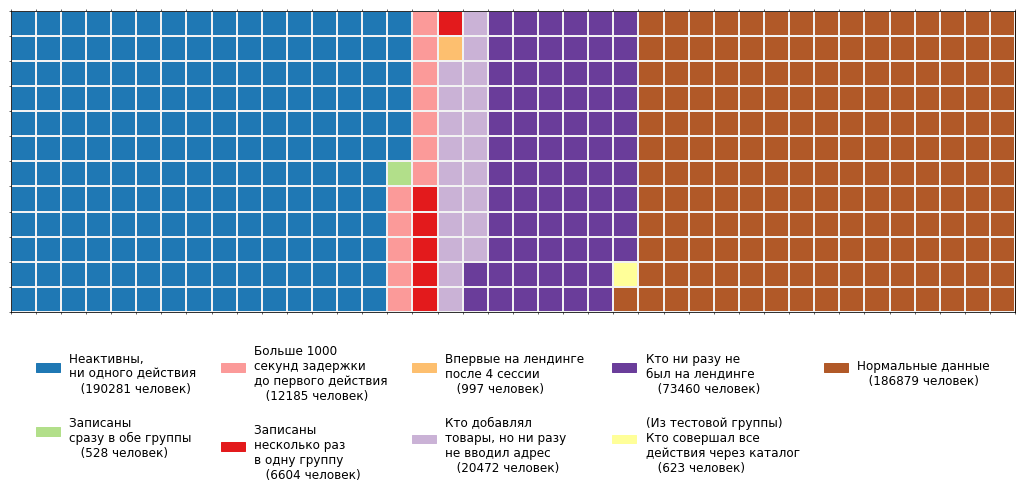

In [60]:
width = 40
height = 12
total = width * height
waffle_data = pd.DataFrame(data = {
    '\nНеактивны, \nни одного действия\n': 190281,
    '\nЗаписаны \nсразу в обе группы\n': 528,
    '\nБольше 1000 \nсекунд задержки \nдо первого действия\n': 12185,
    '\nЗаписаны \nнесколько раз \nв одну группу\n': 6604,
    '\nВпервые на лендинге \nпосле 4 сессии\n': 997,
    '\nКто добавлял \nтовары, но ни разу\nне вводил адрес\n': 20472,
    '\nКто ни разу не\nбыл на лендинге\n': len(never_visited_landing),
    '\n(Из тестовой группы)\nКто совершал все\nдействия через каталог\n': 623,
    '\nНормальные данные\n': 186879}.items(), index = np.arange(1, 10), columns = ['action', 'cnt'])

waffle_data['proportion'] = waffle_data.cnt.apply(lambda x: x / waffle_data.cnt.sum())
waffle_data['tiles_per_category'] = [ round(proportion * total) for proportion in waffle_data['proportion'].values ]

cmap = plt.get_cmap('Paired', 10)
colors = [cmap(i) for i in np.arange(10)]

waffle = np.zeros((height, width, 4))
category_index = 0
tile_index = 0
for col in range(width):
    for row in range(height):
        tile_index += 1
        if tile_index > sum(waffle_data['tiles_per_category'].iloc[0:category_index]):
            category_index += 1
        waffle[row, col] = colors[category_index]

fig, ax = plt.subplots(figsize = (18, 6))
colormap = plt.cm.Paired
plt.matshow(waffle, cmap = colormap, fignum = 0)
ax.set_xticks(np.arange(-0.5, width, 1), minor = True)
ax.set_yticks(np.arange(-0.5, height, 1), minor = True)
ax.grid(which = 'minor', color = '#f2f2f2', linestyle = '-', linewidth = 2)
plt.xticks([])
plt.yticks([])

values = waffle_data['cnt'].values
categories = waffle_data['action'].values
values_cumsum = np.cumsum(values)
total_values = values_cumsum[len(values_cumsum) - 1]
legend_handles = []
for i, category in enumerate(categories):
    label_str = category + '   (' + str(values[i]) + ' человек' + ')'
    color_val = colors[i + 1]
    legend_handles.append(mpatches.Patch(color = color_val, label = label_str))
ax.legend(handles = legend_handles, loc = 'lower center', ncol = 5, frameon = False,
          bbox_to_anchor = (0, -0.6, 1, 0.1), fontsize = 'large') 
plt.savefig('img8.png', bbox_inches = 'tight', pad_inches = 0)

display(fig)
plt.close(fig)

Из-за округления график неизбежно отображает пропорции не в точности. Притом чем лучше график читается (чем меньше плиток умещает площадь фигуры) - тем больше точности срезается на округлении. Нужно иметь в виду, что крупные категории в реальности занимают на этой вафле "больше места".

<a id='target11'></a>
## A/B-тест метрик
[// вернуться к началу](#target100) 

Конверсия не зависит от числа показов лендинга - будем считать исход для одного пользоваля независимой случайной величиной, распределённой по Бернулли. Если бы мы имели ограниченный набор пользователей и показывали бы каждому несколько лендингов, тогда выбор критерия был бы отдельной задачей. Сейчас лучше всего для симуляции данных подойдёт биномиальное распределение, а в качестве критерия - биномиальный z-test.

In [61]:
def binomial_ztest_simulation(trials1, trials2, c1, c2, iters_cnt = 1500, alpha = 0.05, save_name = None):
    sample_a = np.random.binomial(trials1, c1, iters_cnt)
    sample_b_h1 = np.random.binomial(trials2, c2, iters_cnt)
    sample_b_h0 = np.random.binomial(trials2, c1, iters_cnt)
    samples_stacked_h1 = np.column_stack((sample_a, sample_b_h1))
    samples_stacked_h0 = np.column_stack((sample_a, sample_b_h0))
    
    pvalues_ztest_h1 = [proportions_ztest([x[0], x[1]], [trials1, trials2])[1] for x in samples_stacked_h1]
    pvalues_ztest_h0 = [proportions_ztest([x[0], x[1]], [trials1, trials2])[1] for x in samples_stacked_h0]
    
    ecdf_h1 = ECDF(pvalues_ztest_h1)
    ecdf_h0 = ECDF(pvalues_ztest_h0)
    
    sensit_h1 = '{:.2f}'.format(ecdf_h1(alpha))
    if abs(ecdf_h0(alpha) - alpha) > 0.005:
        sensit_h0 = '{:.3f}'.format(ecdf_h0(alpha)) 
    else:
        sensit_h0 = '{:.2f}'.format(ecdf_h0(alpha))
    
    dots = np.linspace(0, 1, iters_cnt)
    xy_ticks_h1 = [alpha] + list(np.arange(0.2, 1.1, 0.2))
    xy_ticks_h0 = [0.01] + list(np.arange(0.05, 0.21, 0.05))
    
    fig, ax1, ax2 = two_subplots((15, 5), 
                                 f"Кривая CDF для значений p-value (выборка из {iters_cnt} биномиальных ztest'ов)", 
                                 [f'при $H1$ и α = {alpha}, доля принятых $H1$ = {sensit_h1}', 
                                  f'при $H0$ и α = {alpha}, доля принятых $H1$ = {sensit_h0}'])
    for ax, ecdf, xy_ticks in zip([ax1, ax2], [ecdf_h1, ecdf_h0], [xy_ticks_h1, xy_ticks_h0]):
        ax.plot(dots, ecdf(dots), linewidth = 2, color = 'k')
        ax.set_xlabel('p-value', fontsize = 12)
        ax.set_ylabel('доля выборки ниже значения по X', fontsize = 13)
        ax.set(xlim = (-0.005, 1), ylim = (0, 1.01), xticks = [alpha] + xy_ticks, yticks = xy_ticks)
        if max(xy_ticks) == 0.2:
            # мультипликатор на 1.04 - чтобы не казалось, что график дошёл до единиц и закончился 
            ax.set_xlim((0, 0.2 * 1.04))
            ax.set_ylim((0, ecdf_h0(0.2) * 1.04))
        ax.grid(b = True, axis = 'both')
        
    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight', pad_inches = 0)    
    display(fig)
    plt.close(fig)

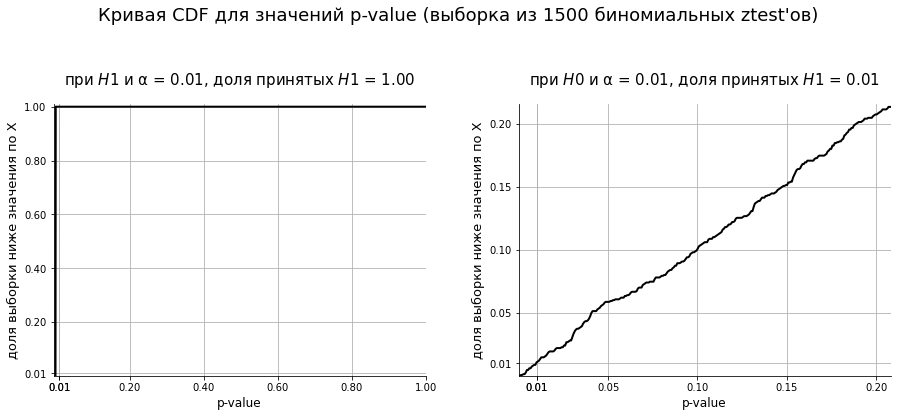

In [62]:
binomial_ztest_simulation(len(trials_c_gr0), len(trials_c_gr1), conv_to_add_gr0, conv_to_add_gr1, alpha = 0.01)

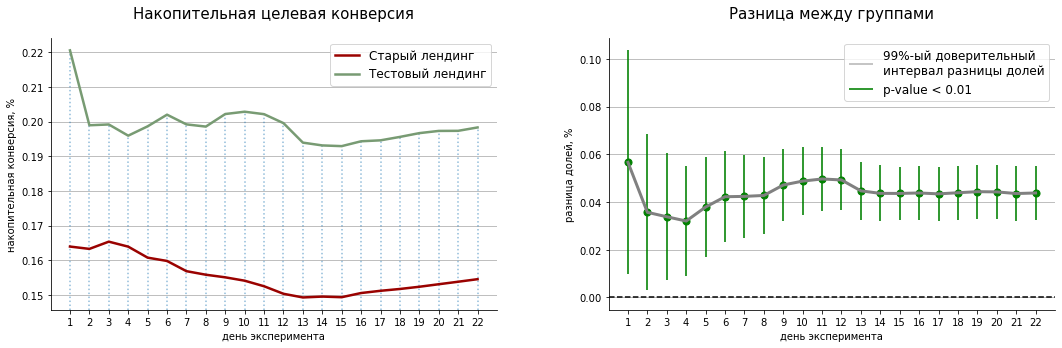

In [63]:
daily = users.copy()
daily['conversion_timestamp'] = daily['conversion_timestamp'].astype('datetime64[D]')
daily['bounce_timestamp'] = daily['bounce_timestamp'].astype('datetime64[D]')

daily_c = (daily.query('activity_aside_landing == 1')
           .groupby(['group', 'conversion_timestamp'])['target_action_done'].agg(['mean', 'count']))
daily_c = daily_c.reset_index().rename({'count': 'trials'}, axis = 1)
daily_c['successes'] = daily_c['mean'].mul(daily_c['trials']).astype('int')
daily_c[['successes_cum', 'trials_cum']] = daily_c.groupby('group')[['successes', 'trials']].cumsum()
ztest_conversion(daily_c, 'conversion_timestamp', 'group', 'trials_cum', 'successes_cum', 
              {'A': 0, 'B': 1}, (18, 5), alpha = 0.01, legend = ['Старый лендинг', 'Тестовый лендинг'],
              title_left = 'Накопительная целевая конверсия', save_name = 'img10.png')

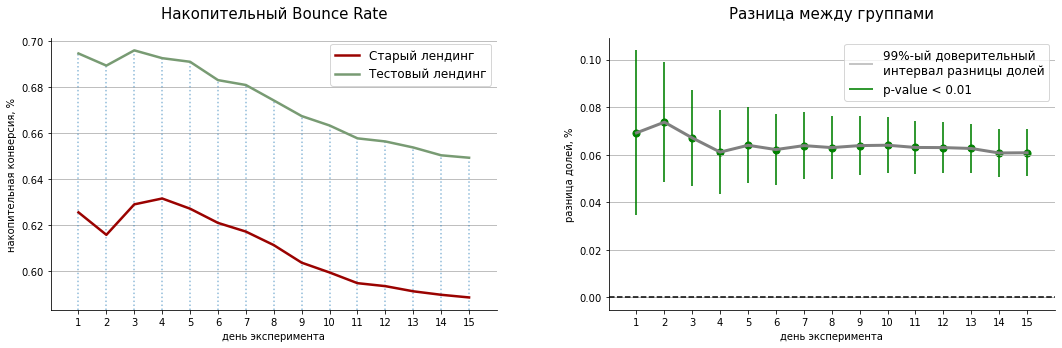

In [64]:
daily_b = (daily.query('started_from_landing == 1')
           .groupby(['group', 'bounce_timestamp'])['bounced_from_landing'].agg(['mean', 'count']))
daily_b = daily_b.reset_index().rename({'count': 'trials'}, axis = 1)
daily_b['successes'] = daily_b['mean'].mul(daily_b['trials']).astype('int')
daily_b[['successes_cum', 'trials_cum']] = daily_b.groupby('group')[['successes', 'trials']].cumsum()
ztest_conversion(daily_b, 'bounce_timestamp', 'group', 'trials_cum', 'successes_cum', 
              {'A': 0, 'B': 1}, (18, 5), alpha = 0.01, legend = ['Старый лендинг', 'Тестовый лендинг'],
              title_left = 'Накопительный Bounce Rate', save_name = 'img11.png')

Дней 15 из-за того, что набор в группы длился две недели. После двух недель ни новых успехов, ни новых отказов не было.

<a id='target12'></a>
## Принятие решения
[// вернуться к началу](#target100) 

<a id='target13'></a>
### Средний чек в группах

Так как контрольная группа больше, в переменную orders_sum попало больше выбросов, отнесённых к контрольной группе - так же, как было со старыми и с прогрессивными пользователями. Если мы, взяв отсортированную выборку целиком, отрежем по 1.5% крайних значений, то получим более адекватую картину.

In [65]:
orders = users[['id', 'group']].merge(orders, on = 'id')
quant_01 = orders.order_sum.quantile(.015)
quant_99 = orders.order_sum.quantile(.985)
orders = orders[ (orders.order_sum > quant_01) & (orders.order_sum < quant_99) ]

In [66]:
few_groups_distribution(orders, grouper = 'group', vars_type = 'continuous', continuous_vars = ['order_sum'],
                        title = 'Выручка с одного заказа по группам')

orders_by_users = (orders.groupby(['id', 'group'])['order_sum'].agg(['mean', 'count']).reset_index()
                         .rename({'mean': 'AvP', 'count': 'APC'}, axis = 1))
few_groups_distribution(orders_by_users, grouper = 'group', 
                        vars_type = 'discrete', discrete_vars = ['APC', 'AvP'], 
                        title = 'Средняя выручка и среднее число заказов на пользователя по группам')

На гистограмме AvP - средний чек за две недели времени для такой выборки пользователей, в которой мы постарались оставить только тех, кто на сайте впервые. Это практически не AvP, а стоимость первых покупок (в 70% случаев - единственной покупки). Сравнивать APC не имеет большого смысла - если кто-то за первые две недели делает больше одной покупки, значит, во-первых, ему понравился опыт от первой покупки (это решающий фактор, лендинг тут точно не при чём), во-вторых, он, скорее всего, пришёл в эксперимент в самые первые дни. Кто за короткое время сделали много заказов - мы расценим как выбросы, так как в этих случях даже опыт от первой покупки обычно не играет большой роли (когда, к примеру, кто-то заказывает доставку коллегам в офис).

Остановимся на AvP. Усреднение по пользователям необходимо для того, чтобы совместить метрики и принять решение - прошлые метрики были 'user centric'. Мы не можем вдруг начать сравнивать стоимость покупок вместо среднего чека. 

Гистограмма AvP напоминает о логнормальном распределении. Возьмём логарифм из вектора средних чеков и проверим на нормальность.

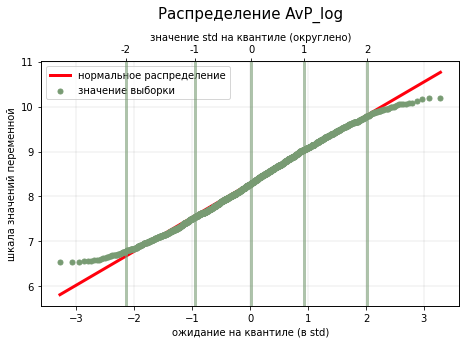

                                   pvalue
Тест Шапиро - Уилка:                1.222933292410744e-07
Тест Колмогорова - Смирнова:        0.22500225293718168


mean       std  count
Код группы                           
0           8.290712  0.761254   1693
1           8.278926  0.705121    268

In [67]:
orders_by_users['AvP_log'] = np.log(orders_by_users['AvP'])
qq_plot(orders_by_users['AvP_log'], alpha = 0.01, title = 'Распределение AvP_log', save_name = 'img12.png')
my_display(orders_by_users.groupby('group')['AvP_log'].agg(['mean', 'std', 'count']), 
           index_name = 'Код группы')

Тест Колмогорова-Смирнова удалось пройти. Полному совпадению с теоретическими квантилями мешают недостаточно низкие значения в нижней части выборки и недостаточно высокие в правой - это слишком тяжелые для логнормального распределения "хвосты" оригинальной выборки.

Данные распределены нормально, не нужно искать непараметрический критерий. Ассиметрии нет, дисперсия равная - поэтому в преобразовании тоже не нуждаются. ttest бы подошёл, но мы сейчас всё равно столкнёмся с нулевой чувствительностью.

In [68]:
def test_simulations(sample_a, sample_b, iters_cnt = 1500, alpha = 0.05, perform = None, save_name = None):
    
    if not perform:
        print('Нужно передать список стат. критериев в параметре "perform"')
        
    cmap = plt.get_cmap('tab10', len(perform) + 1)
        
    a_mean = np.mean(sample_a)
    a_std = np.std(sample_a)
    a_num = len(sample_a)
    
    b_mean = np.mean(sample_b)
    b_std = np.std(sample_b)
    b_num = len(sample_b)
    
    sample_a = np.random.normal(loc = a_mean, scale = a_std, size = (iters_cnt, a_num))
    sample_b_h1 = np.random.normal(loc = b_mean, scale = b_std, size = (iters_cnt, b_num))
    sample_b_h0 = np.random.normal(loc = a_mean, scale = b_std, size = (iters_cnt, b_num))
    
    dots = np.linspace(0, 1, iters_cnt)
    
    sensits = [[], []]
    curves = {}
    def update_curves_dict(pvalues_h1, pvalues_h0, test_name):
        ecdf_h1 = ECDF(pvalues_h1)
        ecdf_h0 = ECDF(pvalues_h0)
        sensit_h1 = ecdf_h1(alpha)
        sensit_h0 = ecdf_h0(alpha)
        upd_dict = {test_name: {'h1': ecdf_h1(dots), 'h0': ecdf_h0(dots), 
                                'sensit': {'h1': '{:.3f}'.format(sensit_h1), 'h0': '{:.3f}'.format(sensit_h0)}}}
        curves.update(upd_dict)
        sensits[0].append(sensit_h0)
        sensits[1].append(sensit_h1)
        
    
    if 'ttest' in perform:
        pvalues_ttest_h1 = list(map(lambda x: st.ttest_ind(x[0], x[1]).pvalue, zip(sample_a, sample_b_h1)))
        pvalues_ttest_h0 = list(map(lambda x: st.ttest_ind(x[0], x[1]).pvalue, zip(sample_a, sample_b_h0)))
        update_curves_dict(pvalues_ttest_h1, pvalues_ttest_h0, 'ttest')
    
    if 'mannwhitney' in perform:
        pvalues_ttest_h1 = list(map(lambda x: st.mannwhitneyu(x[0], x[1], 
                                                    alternative='two-sided').pvalue, zip(sample_a, sample_b_h1)))
        pvalues_ttest_h0 = list(map(lambda x: st.mannwhitneyu(x[0], x[1], 
                                                    alternative='two-sided').pvalue, zip(sample_a, sample_b_h0)))
        update_curves_dict(pvalues_ttest_h1, pvalues_ttest_h0, 'mannwhitney')
    
    if 'bootstrap' in perform:
        def bootstrap(x):
            sample_a = x[0]
            sample_b = x[1]
            bootstraps_cnt = 500
            bootstraps_size = max([len(sample_a), len(sample_b)])
            boot_data = []
            for i in range(bootstraps_cnt):
                bootstrap_sample_a = np.random.choice(sample_a, bootstraps_size, replace = True)
                bootstrap_sample_b = np.random.choice(sample_b, bootstraps_size, replace = True)
                boot_data.append(np.mean(bootstrap_sample_a - bootstrap_sample_b))
            pvalue_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
            pvalue_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
            return min(pvalue_1, pvalue_2) * 2
            
            """
            Мой пуассоновский бутстрап работает медленней, чем классический. Оставил, чтобы было, откуда продолжить
            
            bootstraps_cnt = 1000        
            if len(x[0]) > len(x[1]):
                sample_a = x[0]
                sample_b = x[1]
            else:
                samlpe_a = x[1]
                sample_b = x[0]
            len_a = len(sample_a)
            len_b = len(sample_b)
        
            # чтобы выборки были примерно равного размера, пуассоновское распределение для большей из них центрирую
            # на единицу, а меньшей из них - на частном от деления размера большей выборки на размер меньшей
            ratio = len_a / len_b
            
            # бустрап-выборок - 1000, в каждой по n мультипликаторов (для n наблюдений)
            poisson_coefs_a = st.poisson(1).rvs((bootstraps_cnt, len_a))
            poisson_coefs_b = st.poisson(ratio).rvs((bootstraps_cnt, len_b))
            
            # суммирую мультипикаторы и тысячу раз определяю, в какой бутстрап-выбороке из двух будет меньше элементов.
            # фиксирую индекс последнего элемента в наименьшей выборке, буду этим индексом ограничивать обе выборки,
            # чтобы одну можно было вычесть из другой поэлементно
            constraints = np.amin([np.sum(poisson_coefs_a, axis = 1), np.sum(poisson_coefs_b, axis = 1)], axis = 0)
            
            # возвращаю среднюю разницу элементов каждой из тысячи пар бутстрап-выборок
            bstrp = lambda x: np.mean(np.subtract(np.repeat(sample_a, x[0])[:x[2]], np.repeat(sample_b, x[1])[:x[2]]))
            mean_diffs = list(map(bstrp, zip(poisson_coefs_a, poisson_coefs_b, constraints)))
            
            pvalue_1 = norm.cdf(x = 0, loc = np.mean(mean_diffs), scale = np.std(mean_diffs))
            pvalue_2 = norm.cdf(x = 0, loc = -np.mean(mean_diffs), scale = np.std(mean_diffs))
            return min(pvalue_1, pvalue_2) * 2
            """
        
        pvalues_ttest_h1 = list(map(bootstrap, zip(sample_a, sample_b_h1)))
        pvalues_ttest_h0 = list(map(bootstrap, zip(sample_a, sample_b_h0)))
        update_curves_dict(pvalues_ttest_h1, pvalues_ttest_h0, 'bootstrap')
    
    
    sensits = list(map('{:.3f}'.format, np.array([min(sensits[0]), max(sensits[0]), 
                                                  min(sensits[1]), max(sensits[1])])))
    if len(perform) == 1:
        title = f"Кривая CDF для значений p-value (выборка из {iters_cnt} {perform[0]}'ов)"
    else:
        title = f"Кривая CDF для значений p-value нескольких тестов (по {iters_cnt} повторений каждого теста)"
        
        
    fig, ax1, ax2 = two_subplots((18, 5), title, [f'при $H1$ и α = {alpha}', f'при $H0$ и α = {alpha}'])
    for ax, hypo in zip([ax1, ax2], ['h1', 'h0']):               
        for i, test in enumerate(curves.keys()):
            label = (f"{test}, принятых $H1$: {curves[test]['sensit'][hypo]}")
            ax.plot(dots, curves[test][hypo], linewidth = 2, color = cmap(i), label = label)
                        
        ax.set_xlabel('p-value', fontsize = 12)
        ax.set_ylabel('доля выборки ниже значения по X', fontsize = 13)
        ax.set(xlim = (-0.005, 1), ylim = (0, 1.01))
        ax.grid(b = True, axis = 'both') 
        ax.legend(loc = 'lower right', fontsize = 'large')
    
        
    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight', pad_inches = 0)    
    display(fig)
    plt.close(fig)

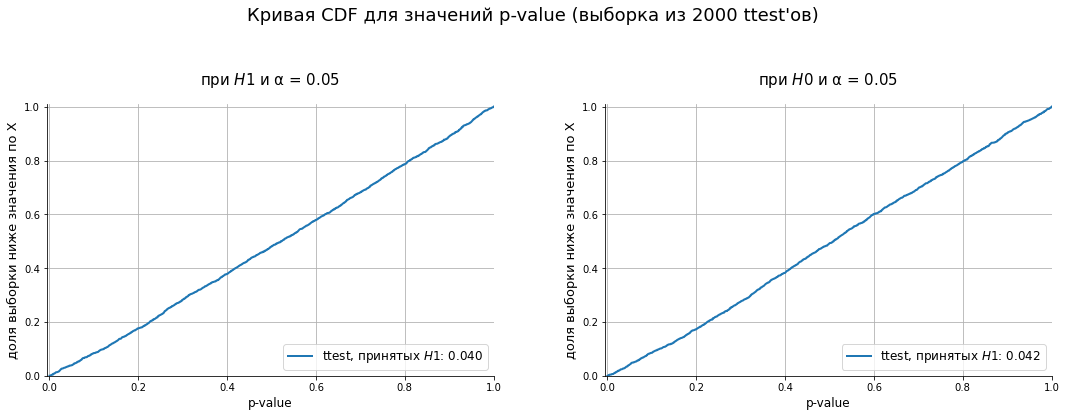

In [69]:
a = orders_by_users.query('group == 0')['AvP_log']
b = orders_by_users.query('group == 1')['AvP_log']
test_simulations(a, b, iters_cnt = 2000, alpha = 0.05, perform = ['ttest'], save_name = 'img14.png')

Опираться на тест при таких размерах выборок - всё равно, что отвечать наугад. 

In [70]:
def vary_sample_sizes(sample_a, sample_b, alpha = 0.05, sensitivity = 0.95, perform = None, 
                      iters_cnt = 25, title = None, save_name = None):
    from IPython import get_ipython
    
    if not perform:
        print('Нужно передать список стат. критериев в параметре "perform ="')
    
    if not title:
        title = f'Рост чувствительности при увеличении выборок, α = {alpha}\n(по {iters_cnt} тестов на точку)'
    cmap = plt.get_cmap('tab10', len(perform) + 1)
    
    # у меня компьютер не сможет одновременно обсчитывать больше ста случайных выборок большого размера.
    # поэтому разбиваем iters_cnt на целые сотни плюс остаток, будем считать по частям
    if (iters_cnt % 100) != 0:
        iters = np.repeat(100, (iters_cnt // 100) + 1)
        iters[-1] = iters_cnt % 100
    else:
        iters = np.repeat(100, (iters_cnt // 100))
    
    sample_a = np.array(sample_a).reshape(-1)
    sample_b = np.array(sample_b).reshape(-1)
    a_mean = np.mean(sample_a)
    a_std = np.std(sample_a)
    a_num = len(sample_a)
    b_mean = np.mean(sample_b)
    b_std = np.std(sample_b)
    b_num = len(sample_b)
    
    sd = abs(a_mean - b_mean)/np.std(np.concatenate([sample_a, sample_b]))
    if a_num >= b_num:
        biggest_by_now = a_num
        ratio = b_num/a_num
        A_is_bigger = True
    else:
        biggest_by_now = b_num
        ratio = a_num/b_num
        A_is_bigger = False
    bigger_sample_num = tt_ind_solve_power(sd, alpha = alpha, power = sensitivity, 
                                           ratio = ratio, alternative = 'two-sided')
    if biggest_by_now >= bigger_sample_num:
        print('Выборки уже достигли достаточных размеров, тестируй')
    
    sizes = np.linspace(biggest_by_now, bigger_sample_num, 10, dtype = 'int')
    spread = bigger_sample_num - a_num

    perform_dict, sensitivity_values = {}, {}
    
    if 'ttest' in perform:
        func = lambda x: st.ttest_ind(x[0], x[1]).pvalue
        perform_dict.update({'ttest': func})
        sensitivity_values['ttest'] = {}
        
    if 'mannwhitney' in perform:
        func = lambda x: st.mannwhitneyu(x[0], x[1], alternative='two-sided').pvalue
        perform_dict.update({'mannwhitney': func})
        sensitivity_values['mannwhitney'] = {}
    
    # т.к. считаем по частям, будем по ключу [size] постепенно прибавлять кол-во найденных различий
    for statname in perform_dict.keys():
        for size in sizes:
            sensitivity_values[statname][size] = 0
        
    for iter_cnt in iters:
        if A_is_bigger:
            for size in sizes:
                A = np.random.normal(loc = a_mean, scale = a_std, size = (iter_cnt, size))
                B = np.random.normal(loc = b_mean, scale = b_std, size = (iter_cnt, int(size * ratio)))
                for statname, stattest in perform_dict.items():
                    pvalues_test = np.array(list(map(stattest, zip(A, B))))
                    caught_h1 = len(pvalues_test[ pvalues_test < alpha ])
                    sensitivity_values[statname][size] += caught_h1
                del A
                del B
                gc.collect()
        else:
            for size in sizes:
                A = np.random.normal(loc = a_mean, scale = a_std, size = (iter_cnt, size))
                B = np.random.normal(loc = b_mean, scale = b_std, size = (iter_cnt, int(size * ratio)))
                for statname, stattest in perform_dict.items():
                    pvalues_test = np.array(list(map(stattest, zip(A, B))))
                    caught_h1 = len(pvalues_test[ pvalues_test < alpha ])
                    sensitivity_values[statname][size] += caught_h1
                del A
                del B
                gc.collect()
                        

    fig, ax = plt.subplots(figsize = (14, 5))
    ax.set_title(title, y = 1.1, fontsize = 16)
    ax.set_xticks(sizes)
    ax.set_xticklabels([int(x) for x in (sizes * ratio)], rotation = 45, ha = 'right', fontsize = 13) 
    ax.set_ylabel('сколько истинных H1 удалось принять', fontsize = 13)
    ax.set_xlabel('размер наименьшей из выборок', fontsize = 13)
    ax.set_xlim(a_num - spread * 0.1, bigger_sample_num + spread * 0.1)
    ax.grid(b = True, axis = 'both')
    
    for i, test_name in enumerate(perform_dict.keys()):
        x, y = [], []
        for size, successes in sensitivity_values[test_name].items():
            x.append(size)
            y.append(successes / iters_cnt)
        ax.plot(x, y, linewidth = 2, color = cmap(i), label = test_name, marker = 'o', ms = 8, 
                mfc = cmap(i), mec = '#f2f2f2', mew = 2)
        
    ax.legend(fontsize = 'x-large')
    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight', pad_inches = 0) 
    display(fig)
    plt.close(fig)

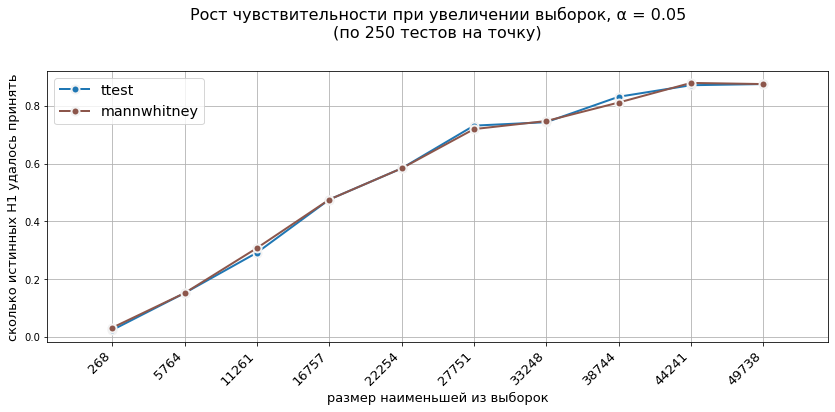

In [71]:
vary_sample_sizes(a, b, alpha = 0.05, sensitivity = 0.9, iters_cnt = 250, 
                  perform = ['ttest', 'mannwhitney'], save_name = 'img15.png')

T-test с 20%-ой вероятностью ошибки второго рода и 5%-ым уровнем значимости будет обнаруживать данные различия тогда, когда в тестовой выборке наберётся 39’000 пользователей, дошедших до покупки, а в контрольной, соответственно, 351’000.

Гипотеза о различии в средних чеках не нашла подтверждения. Поэтому чтобы принять на основе данных решение, будет достаточно посчитать конверсию из посещения лендинга в первую покупку.


<a id='target14'></a>
### Конверсия в покупку
[// вернуться к началу](#target100) 

In [72]:
divider_for_c1 = users.query('(activity_aside_landing == 1) & (target_action_done == 1)')['id'].unique()
c1 = logs[ (logs.event == 9) & logs.id.isin(divider_for_c1) ].groupby('id')['timestamp'].min().reset_index()
users.loc[ users.id.isin(c1.id), 'c1' ] = 1
users['c1'] = users['c1'].fillna(0).astype('int')
c1_failed = users.loc[ (users.c1 == 0) & (users.id.isin(divider_for_c1)) ]['id'].unique()

# если неудача с c1, то временем этой неудачи будем считать время первого добавления товара в корзину
c1_failed_timestamps = (users[ users.id.isin(c1_failed) ][['id', 'conversion_timestamp']]
                        .rename({'conversion_timestamp': 'timestamp'}, axis = 1))
users = (users.merge(c1.append(c1_failed_timestamps), on = 'id', how = 'left')
         .rename({'timestamp': 'c1_timestamp'}, axis = 1))
c1 = users.query('target_action_done == 1').groupby('group')['c1'].agg(['mean', 'count']).reset_index()

cart_to_c1_gr0 = c1.loc[0, 'mean']
cart_to_c1_gr1 = c1.loc[1, 'mean']

print('\nКонверсия из пополнения\nкорзины в покупку')
print('{: <35}'.format('   - текущей версии лендинга: '), 
      '{:.2%}'.format(cart_to_c1_gr0))
print('{: <35}'.format('   - тестовой версии лендинга: '), 
      '{:.2%}'.format(cart_to_c1_gr1))
print('{: <35}'.format('     Размер групп: '), 
      f'{c1.loc[0, "count"]} / {c1.loc[1, "count"]}')


Конверсия из пополнения
корзины в покупку
   - текущей версии лендинга:       15.38%
   - тестовой версии лендинга:      11.19%
     Размер групп:                  10722 / 1510


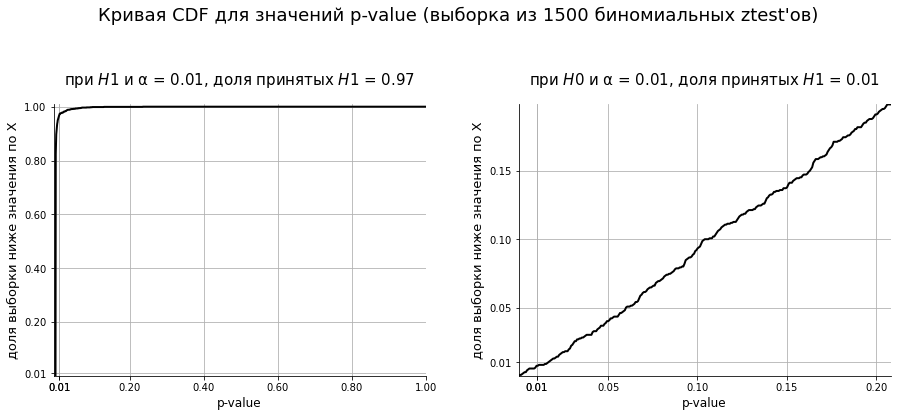

In [73]:
binomial_ztest_simulation(c1.loc[0, "count"], c1.loc[1, "count"], cart_to_c1_gr0, cart_to_c1_gr1, alpha = 0.01,
                          save_name = 'img8.png')

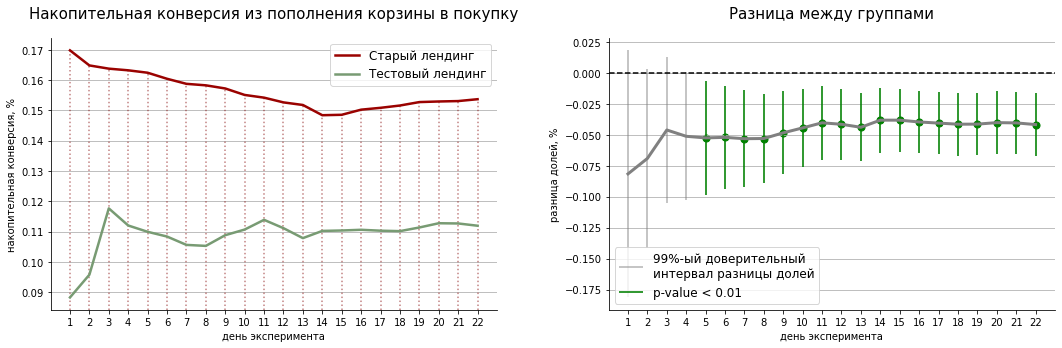

In [74]:
users['c1_timestamp'] = users['c1_timestamp'].astype('datetime64[D]')
daily_c1 = (users.query('target_action_done == 1')
            .groupby(['group', 'c1_timestamp'])['c1'].agg(['mean', 'count']))
daily_c1 = daily_c1.reset_index().rename({'count': 'trials'}, axis = 1)
daily_c1['successes'] = daily_c1['mean'].mul(daily_c1['trials']).astype('int')
daily_c1[['successes_cum', 'trials_cum']] = daily_c1.groupby('group')[['successes', 'trials']].cumsum()
ztest_conversion(daily_c1, 'c1_timestamp', 'group', 'trials_cum', 'successes_cum', 
              {'A': 0, 'B': 1}, (18, 5), alpha = 0.01, legend = ['Старый лендинг', 'Тестовый лендинг'],
              title_left = 'Накопительная конверсия из пополнения корзины в покупку', save_name = 'img13.png')

In [75]:
c1_gr1 = 1 * (1 - bounce_gr1) * conv_to_add_gr1 * cart_to_c1_gr1
c1_gr0 = 1 * (1 - bounce_gr0) * conv_to_add_gr0 * cart_to_c1_gr0

print(f'C текущей версии сайта до первой покупки доходят {round(c1_gr0 * 1000)} из 1000 пользователей', 
      '({:.5f})'.format(c1_gr0))
print(f'C тестовой версии сайта до первой покупки доходят {round(c1_gr1 * 1000)} из 1000 пользователей', 
      '({:.5f})'.format(c1_gr1))

C текущей версии сайта до первой покупки доходят 10 из 1000 пользователей (0.00978)
C тестовой версии сайта до первой покупки доходят 8 из 1000 пользователей (0.00779)


Если команда верит в новую версию лендинга, то можно перезапустить A/B-эксперимент (и даже стоит это сделать, потому что на кону существенные изменения) и провести его, исправив недостатки этого эксперимента. На случай, если тест окончится так же - пусть в отдельной таблице будет стратификация всех, кто участвует в эксперименте. Тогда можно будет изучить целевые метрики в разрезе подгрупп пользователей и, скорее всего, найти объяснение, почему метрики принимают не те значения, какие мы ждём.

[// вернуться к началу](#target100) 